In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 1
EPOCH =50

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "hardtanh"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adabelief"
GEN_init_lr = 2e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
       ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(discriminator, True)
        dis_optimizer.zero_grad()

        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr.detach())
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _dis = nn.BCELoss()(y_cls.float(), torch.ones(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))

        _dis.backward()
        dis_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(discriminator, False)
        gen_optimizer.zero_grad()
        
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # adversarial loss
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))

        # auxilary loss
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = _gen + air_loss*2 + bone_loss*5 + _mae + _ssim
        _loss.backward()    
        gen_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()
        
    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), bone_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [13]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.ones(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.zeros(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [14]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
from codes.activation import Activation
import torchvision.models as models

In [16]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=2048, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [17]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [18]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [19]:
trainset = Dataset(path=train_case_path, geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [20]:
len(trainset), len(testset)

(1344, 191)

In [21]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f0a7ed8d190>,)

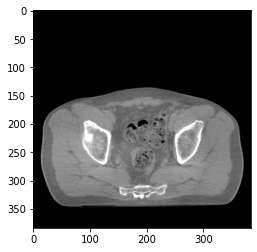

In [22]:
plt.imshow(x.squeeze(), 'gray'),

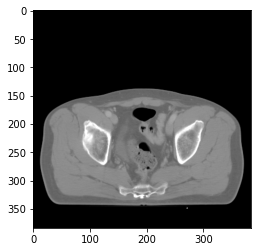

In [23]:
plt.imshow(y.squeeze(), 'gray')

In [24]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [25]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [27]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [28]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [29]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [30]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_bone, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [02:30,  1.12it/s]
168it [00:37,  4.48it/s]
24it [00:05,  4.24it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.23it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.46it/s]
24it [00:05,  4.21it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.46it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:32,  1.10it/s]
168it [00:37,  4.46it/s]
24it [00:05,  4.20it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.46it/s]
24it [00:05,  4.22it/s]
168it [02:32,  1.10it/s]
168it [00:37,  4.44it/s]
24it [00:05,  4.23it/s]
168it [02:31,  1.11it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.20it/s]
168it [02:31,  1.11it/s]
168it [00:37,

In [31]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [32]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [33]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.9039077162742615
psnr score = 26.95509910583496
snr score = 17.018035888671875
mae error = 0.014414859004318714
air dice score = 0.9927284909155473
bone dice score = 0.9599077011831568


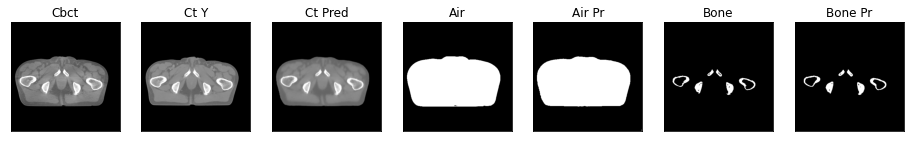

ssim score = 0.904882550239563
psnr score = 26.93222999572754
snr score = 17.042701721191406
mae error = 0.014563694596290588
air dice score = 0.9935255337990815
bone dice score = 0.961187214612426


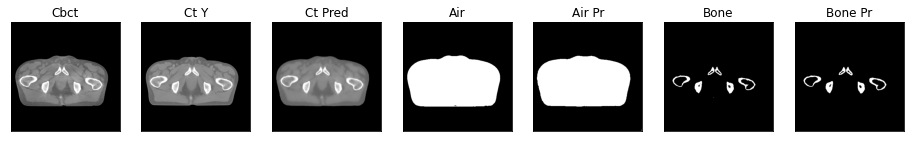

ssim score = 0.9027413129806519
psnr score = 26.718156814575195
snr score = 16.991527557373047
mae error = 0.015495163388550282
air dice score = 0.994361068739857
bone dice score = 0.9495215311010822


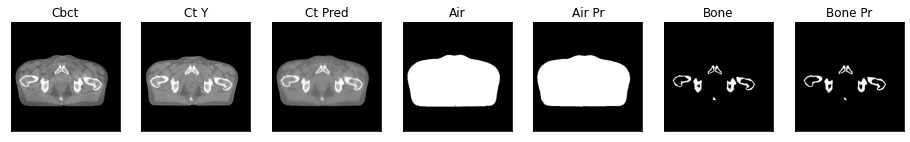

ssim score = 0.900043785572052
psnr score = 26.740617752075195
snr score = 17.103240966796875
mae error = 0.0157163143157959
air dice score = 0.9954760050858027
bone dice score = 0.9441711229952495


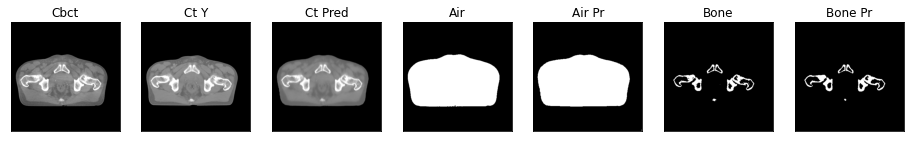

ssim score = 0.8990893363952637
psnr score = 26.842891693115234
snr score = 17.24581527709961
mae error = 0.015704507008194923
air dice score = 0.9955598627414183
bone dice score = 0.9362237491538157


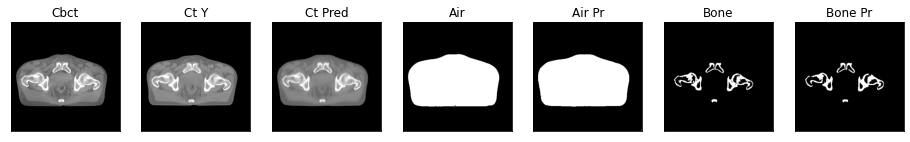

ssim score = 0.8950580954551697
psnr score = 26.710927963256836
snr score = 17.25038719177246
mae error = 0.016349518671631813
air dice score = 0.9960145107588372
bone dice score = 0.9262281432146026


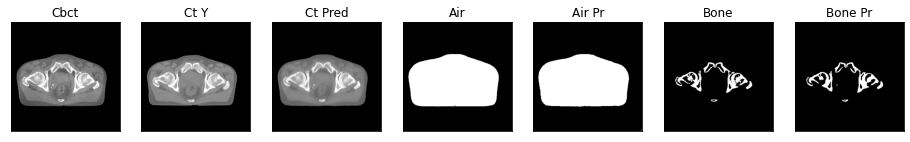

ssim score = 0.8936107754707336
psnr score = 26.773273468017578
snr score = 17.288677215576172
mae error = 0.016282709315419197
air dice score = 0.9958798351934118
bone dice score = 0.9362546638093494


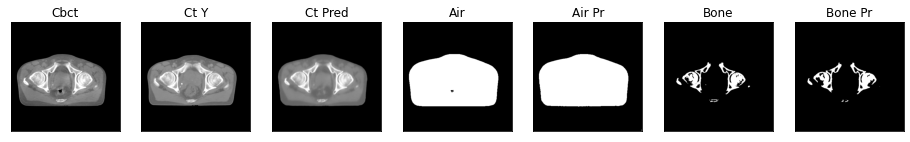

ssim score = 0.8967145085334778
psnr score = 27.225656509399414
snr score = 17.555522918701172
mae error = 0.015492181293666363
air dice score = 0.9962053728699296
bone dice score = 0.9472679965312466


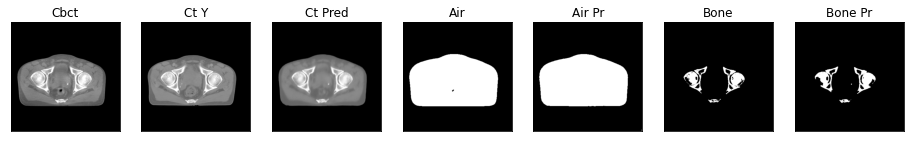

1it [00:02,  2.77s/it]

ssim score = 0.9002217054367065
psnr score = 27.39624786376953
snr score = 17.63155746459961
mae error = 0.014885629527270794
air dice score = 0.9959997164355995
bone dice score = 0.953389429895496


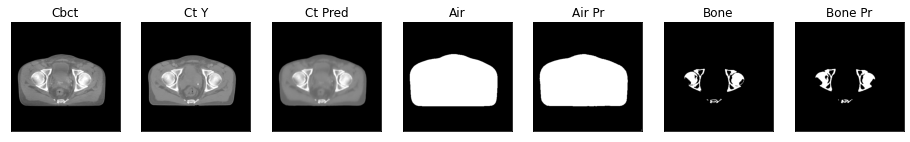

ssim score = 0.9039887189865112
psnr score = 27.68735694885254
snr score = 17.907384872436523
mae error = 0.014458038844168186
air dice score = 0.9952807591556379
bone dice score = 0.9467642984370991


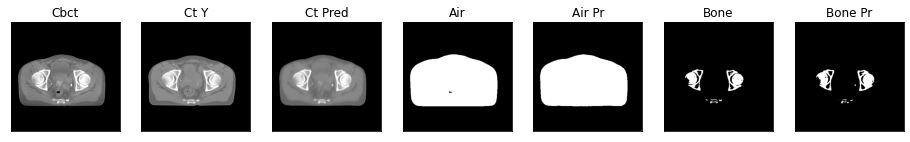

ssim score = 0.9075637459754944
psnr score = 27.897716522216797
snr score = 18.150012969970703
mae error = 0.01415043231099844
air dice score = 0.9954770622442433
bone dice score = 0.9615384615388657


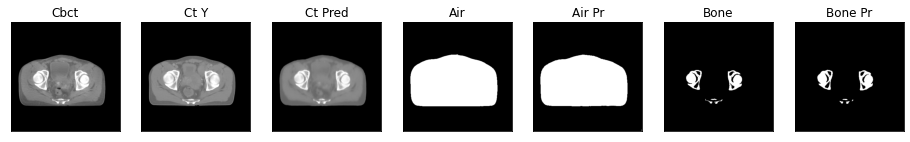

ssim score = 0.9091393351554871
psnr score = 27.849369049072266
snr score = 18.125377655029297
mae error = 0.014351335354149342
air dice score = 0.9918535923897939
bone dice score = 0.9657778710900087


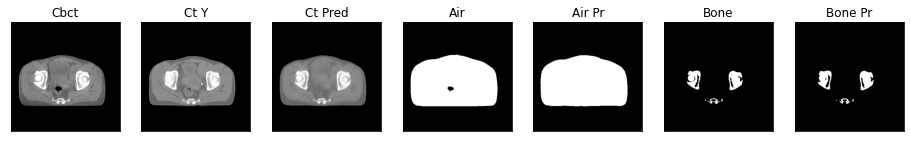

ssim score = 0.915623664855957
psnr score = 28.022884368896484
snr score = 18.266969680786133
mae error = 0.014209856279194355
air dice score = 0.9895706097904835
bone dice score = 0.9704276615108004


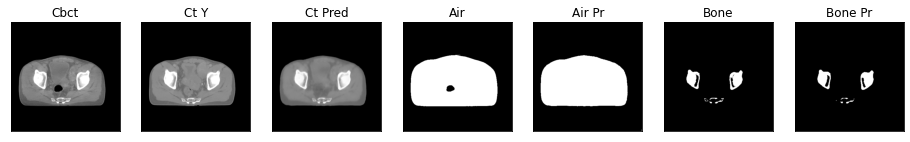

ssim score = 0.9119802713394165
psnr score = 27.834545135498047
snr score = 17.93667221069336
mae error = 0.01468702033162117
air dice score = 0.9884124413787424
bone dice score = 0.9484973188683314


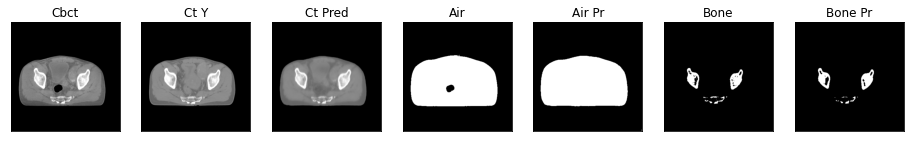

ssim score = 0.9101848006248474
psnr score = 27.660785675048828
snr score = 17.6772518157959
mae error = 0.014689379371702671
air dice score = 0.9896418557900972
bone dice score = 0.9339547270315053


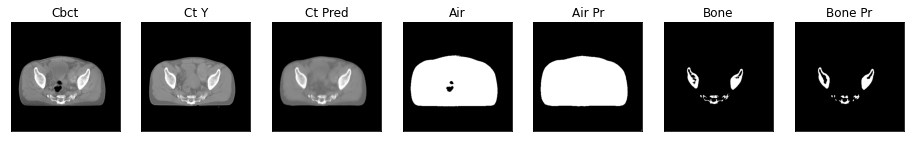

ssim score = 0.902849555015564
psnr score = 26.88663673400879
snr score = 16.92658805847168
mae error = 0.01573200523853302
air dice score = 0.9906366841718518
bone dice score = 0.9414584910428784


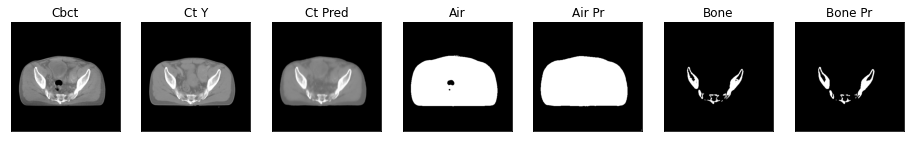

2it [00:05,  2.61s/it]

ssim score = 0.898436427116394
psnr score = 26.201669692993164
snr score = 16.239078521728516
mae error = 0.0165700763463974
air dice score = 0.988077303835075
bone dice score = 0.9416965352456188


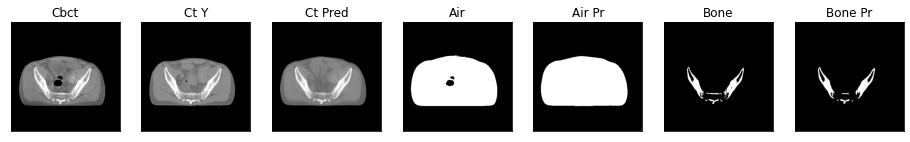

ssim score = 0.8943579792976379
psnr score = 25.751148223876953
snr score = 15.68679428100586
mae error = 0.017126714810729027
air dice score = 0.986042773197795
bone dice score = 0.922082672845725


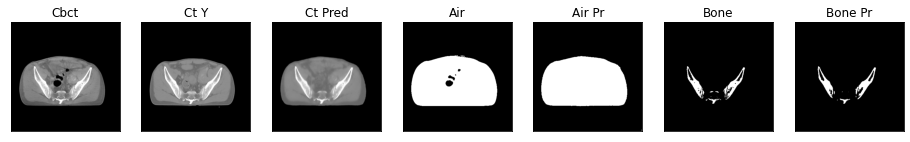

ssim score = 0.8939036130905151
psnr score = 25.32482147216797
snr score = 15.209787368774414
mae error = 0.017569320276379585
air dice score = 0.986403427081408
bone dice score = 0.9178732494669133


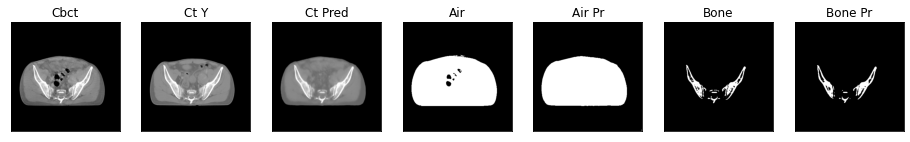

ssim score = 0.8925831317901611
psnr score = 24.749523162841797
snr score = 14.622177124023438
mae error = 0.018511705100536346
air dice score = 0.9886672410365291
bone dice score = 0.928252743278328


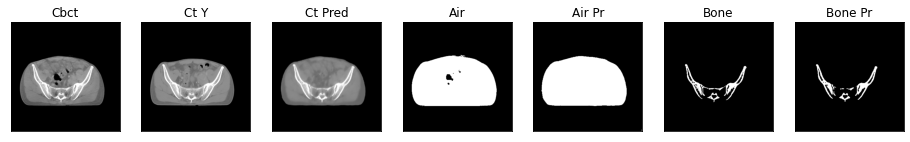

ssim score = 0.886841893196106
psnr score = 24.28109359741211
snr score = 14.088902473449707
mae error = 0.019293811172246933
air dice score = 0.9883462880976143
bone dice score = 0.9132456489980969


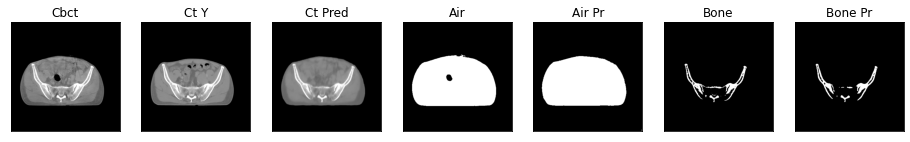

ssim score = 0.8852123022079468
psnr score = 23.95403289794922
snr score = 13.702413558959961
mae error = 0.019426152110099792
air dice score = 0.9903769316480879
bone dice score = 0.9324237353593459


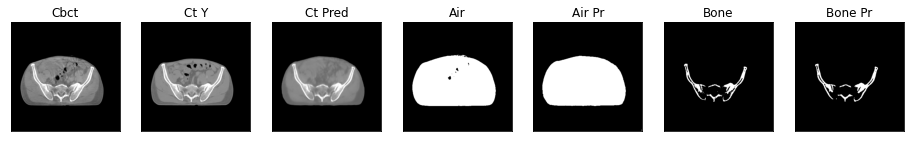

ssim score = 0.8868424892425537
psnr score = 23.85650634765625
snr score = 13.57145881652832
mae error = 0.01948208175599575
air dice score = 0.9911737943585178
bone dice score = 0.9340501792122574


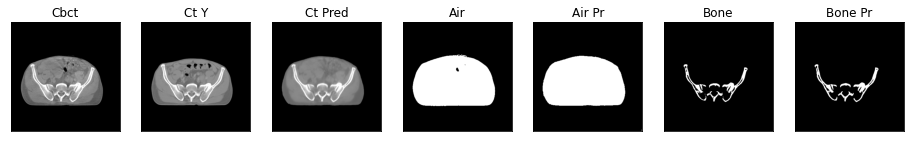

ssim score = 0.8854197859764099
psnr score = 23.558361053466797
snr score = 13.224749565124512
mae error = 0.02017000876367092
air dice score = 0.9920239052982508
bone dice score = 0.9250439882706739


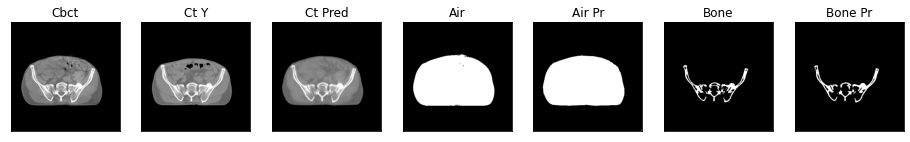

3it [00:07,  2.44s/it]

ssim score = 0.8867257833480835
psnr score = 23.5476016998291
snr score = 13.116989135742188
mae error = 0.020094536244869232
air dice score = 0.9904035633912963
bone dice score = 0.9296408870884877


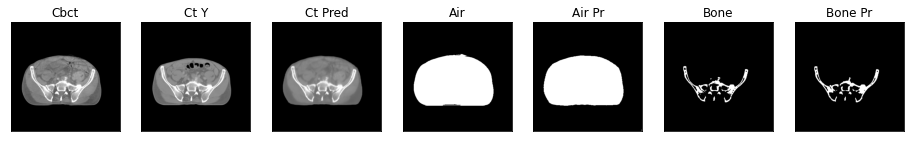

ssim score = 0.889066755771637
psnr score = 23.76842498779297
snr score = 13.255077362060547
mae error = 0.019331099465489388
air dice score = 0.9914411894247009
bone dice score = 0.9099150141653266


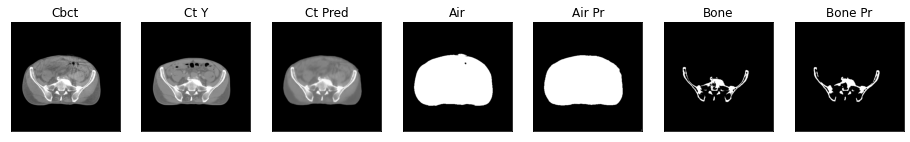

ssim score = 0.8879897594451904
psnr score = 23.8032169342041
snr score = 13.19868278503418
mae error = 0.01960655488073826
air dice score = 0.9913476124021705
bone dice score = 0.913101604279043


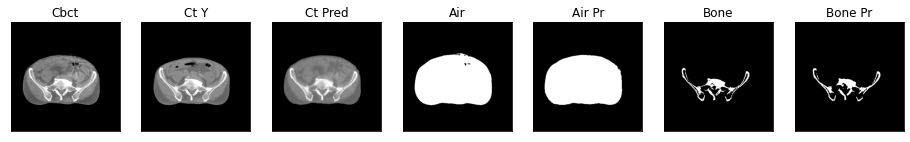

ssim score = 0.8888454437255859
psnr score = 23.659164428710938
snr score = 13.013525009155273
mae error = 0.01998186483979225
air dice score = 0.990035018738109
bone dice score = 0.9280050083479966


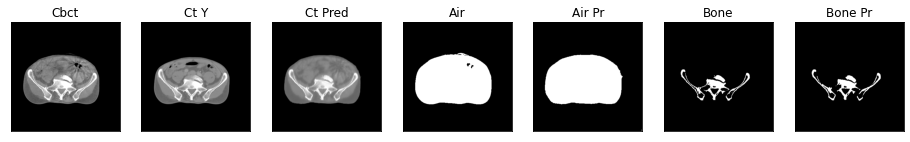

ssim score = 0.8732143044471741
psnr score = 23.915407180786133
snr score = 15.28756332397461
mae error = 0.02083665505051613
air dice score = 0.9916088658713329
bone dice score = 0.9802197802204012


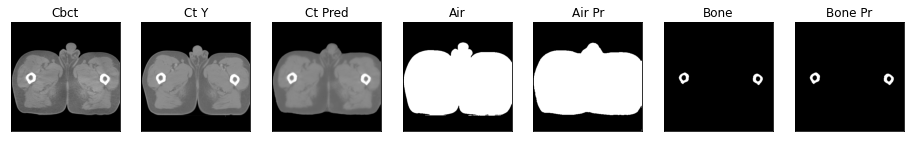

ssim score = 0.8790522813796997
psnr score = 24.6297664642334
snr score = 16.041181564331055
mae error = 0.019220104441046715
air dice score = 0.9918548051757504
bone dice score = 0.9803691766779851


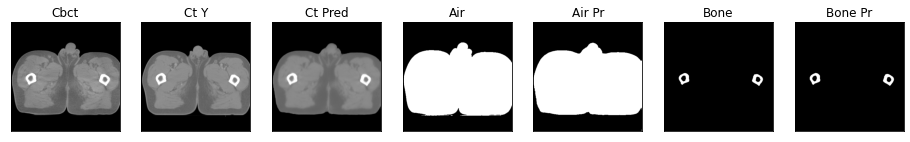

ssim score = 0.8861978054046631
psnr score = 25.28304672241211
snr score = 16.78190803527832
mae error = 0.018409403041005135
air dice score = 0.9924030630849687
bone dice score = 0.9678177120045145


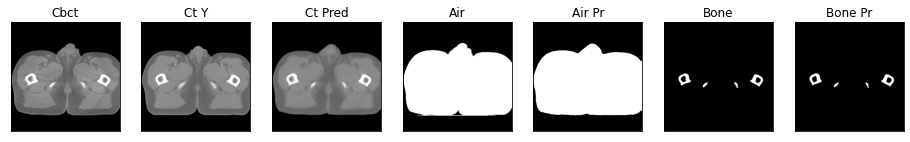

ssim score = 0.8930754661560059
psnr score = 25.881759643554688
snr score = 17.543180465698242
mae error = 0.018188240006566048
air dice score = 0.9937168532259371
bone dice score = 0.9711277715748743


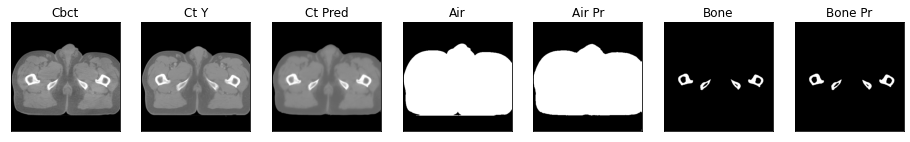

4it [00:09,  2.38s/it]

ssim score = 0.8956282138824463
psnr score = 26.382884979248047
snr score = 18.172447204589844
mae error = 0.017662303522229195
air dice score = 0.9943311545528514
bone dice score = 0.9601976393088087


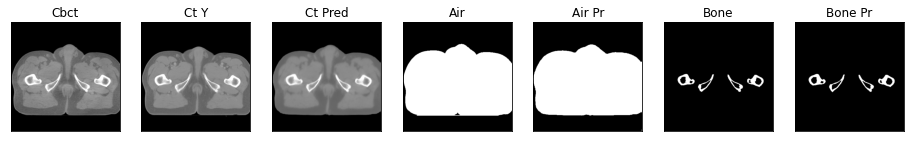

ssim score = 0.8994186520576477
psnr score = 27.109289169311523
snr score = 19.002090454101562
mae error = 0.016861602663993835
air dice score = 0.994594270286489
bone dice score = 0.9569252736797128


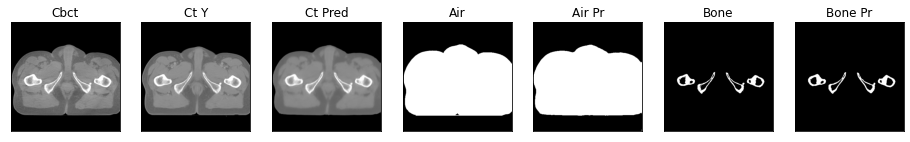

ssim score = 0.9018418788909912
psnr score = 27.58857536315918
snr score = 19.548477172851562
mae error = 0.016727717593312263
air dice score = 0.995075481395602
bone dice score = 0.950043630017997


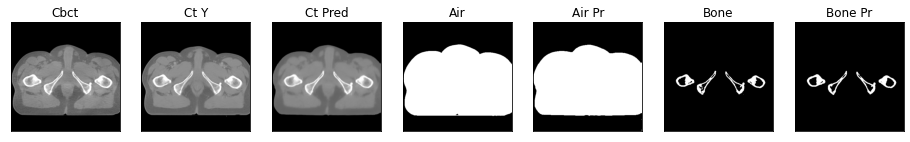

ssim score = 0.9003106355667114
psnr score = 27.707313537597656
snr score = 19.65732765197754
mae error = 0.016449877992272377
air dice score = 0.9954261211363258
bone dice score = 0.9606054323039539


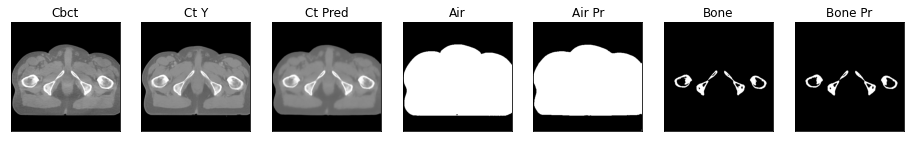

ssim score = 0.9029480218887329
psnr score = 27.8624324798584
snr score = 19.798782348632812
mae error = 0.01627523824572563
air dice score = 0.995647002854427
bone dice score = 0.9640332001233319


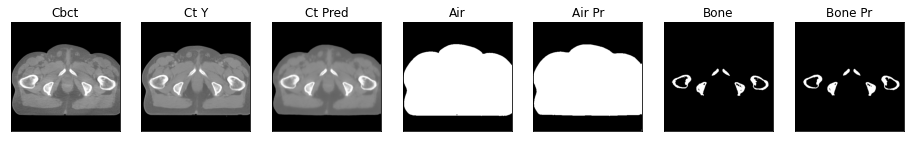

ssim score = 0.9048315286636353
psnr score = 27.962295532226562
snr score = 19.910646438598633
mae error = 0.01628079265356064
air dice score = 0.9960482282296561
bone dice score = 0.9565217391309073


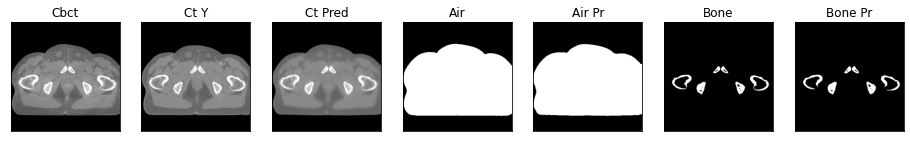

ssim score = 0.9056629538536072
psnr score = 28.06228256225586
snr score = 20.049715042114258
mae error = 0.01611091010272503
air dice score = 0.9960785244335835
bone dice score = 0.9557323770037461


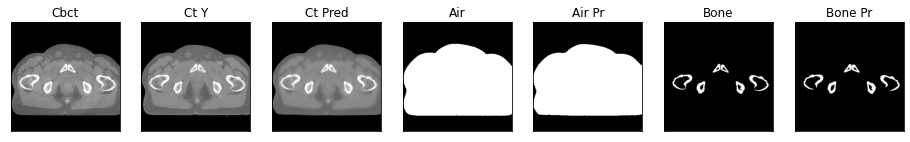

ssim score = 0.9049697518348694
psnr score = 27.99016761779785
snr score = 20.11888885498047
mae error = 0.01674339920282364
air dice score = 0.9960832720108267
bone dice score = 0.9566628484158394


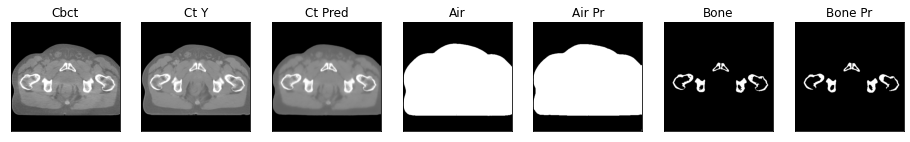

5it [00:11,  2.29s/it]

ssim score = 0.9031791687011719
psnr score = 27.966768264770508
snr score = 20.19017791748047
mae error = 0.017093287780880928
air dice score = 0.9965298409906611
bone dice score = 0.9564942255975598


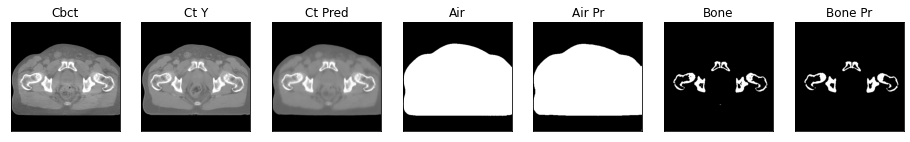

ssim score = 0.8937645554542542
psnr score = 27.324235916137695
snr score = 19.513599395751953
mae error = 0.01863420568406582
air dice score = 0.9963109747012746
bone dice score = 0.9299623115583389


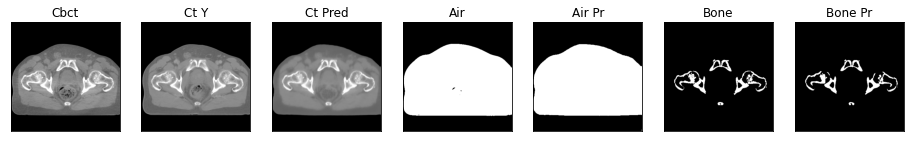

ssim score = 0.8943641781806946
psnr score = 27.554628372192383
snr score = 19.816177368164062
mae error = 0.018178824335336685
air dice score = 0.9952290019215717
bone dice score = 0.9114941745594366


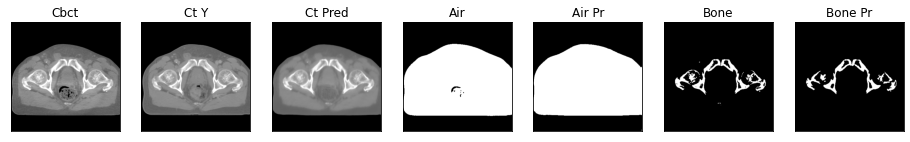

ssim score = 0.8887059092521667
psnr score = 27.222732543945312
snr score = 19.348186492919922
mae error = 0.01851324364542961
air dice score = 0.9951277537803493
bone dice score = 0.8921069098069893


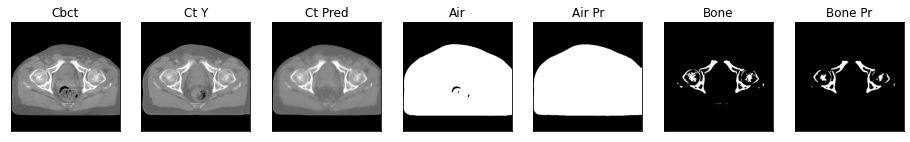

ssim score = 0.8917871713638306
psnr score = 26.93202018737793
snr score = 18.87891387939453
mae error = 0.018073830753564835
air dice score = 0.9947517790324264
bone dice score = 0.8910673201971485


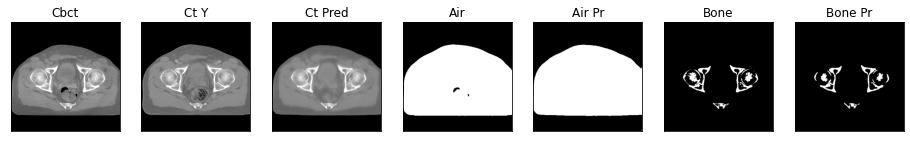

ssim score = 0.8892289400100708
psnr score = 26.316434860229492
snr score = 18.172740936279297
mae error = 0.018903622403740883
air dice score = 0.9958962643313474
bone dice score = 0.8817446043178759


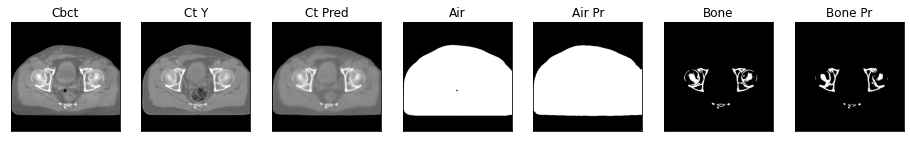

ssim score = 0.8898043632507324
psnr score = 26.115413665771484
snr score = 17.98740577697754
mae error = 0.019058775156736374
air dice score = 0.9955838491583827
bone dice score = 0.8985871271596171


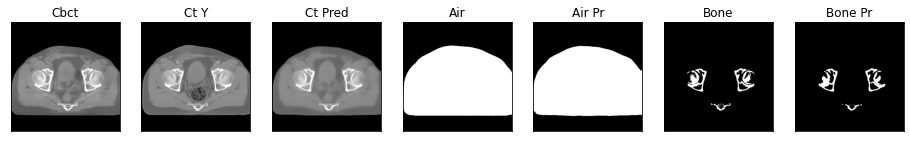

ssim score = 0.8790290355682373
psnr score = 25.95586585998535
snr score = 17.837894439697266
mae error = 0.02004842273890972
air dice score = 0.9956272672863434
bone dice score = 0.9156492785801364


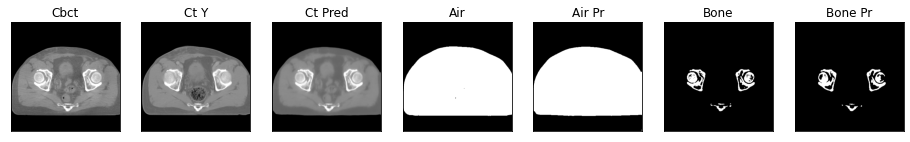

6it [00:13,  2.28s/it]

ssim score = 0.8869956135749817
psnr score = 26.48705291748047
snr score = 18.430673599243164
mae error = 0.018949810415506363
air dice score = 0.9957283552635637
bone dice score = 0.9455849394895062


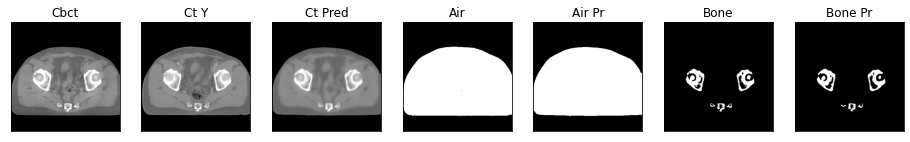

ssim score = 0.8909817934036255
psnr score = 27.446392059326172
snr score = 19.460094451904297
mae error = 0.01799667812883854
air dice score = 0.9957484456022242
bone dice score = 0.9658874458877412


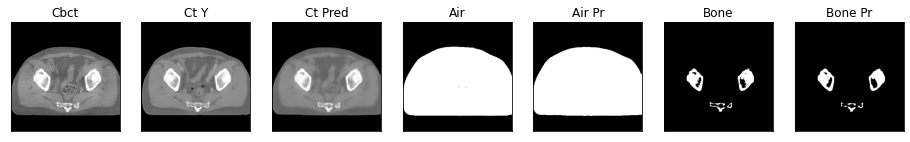

ssim score = 0.8941289186477661
psnr score = 26.95379638671875
snr score = 18.8483943939209
mae error = 0.018265867605805397
air dice score = 0.9957972866692908
bone dice score = 0.9491096623533218


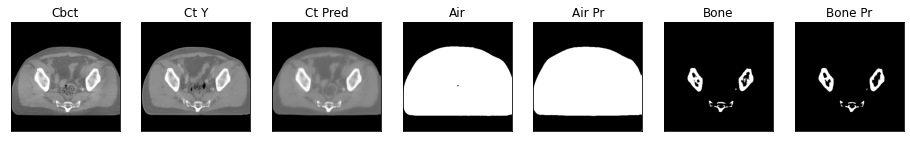

ssim score = 0.8910292983055115
psnr score = 26.45970916748047
snr score = 18.435932159423828
mae error = 0.019713696092367172
air dice score = 0.9948886611728498
bone dice score = 0.9620571237125215


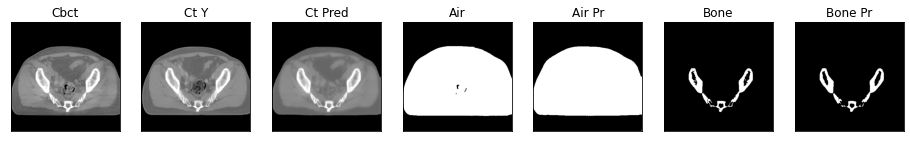

ssim score = 0.8898143768310547
psnr score = 26.647768020629883
snr score = 18.70414161682129
mae error = 0.019498374313116074
air dice score = 0.9938452323470667
bone dice score = 0.9549866366580744


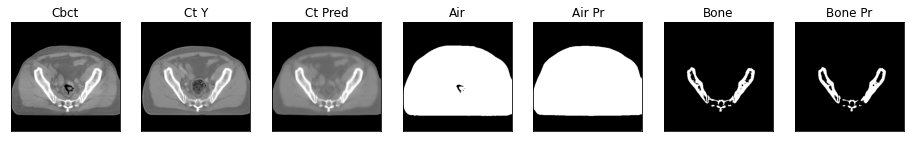

ssim score = 0.8735349178314209
psnr score = 26.031097412109375
snr score = 18.109027862548828
mae error = 0.02151906117796898
air dice score = 0.9929722975649937
bone dice score = 0.9484867547358042


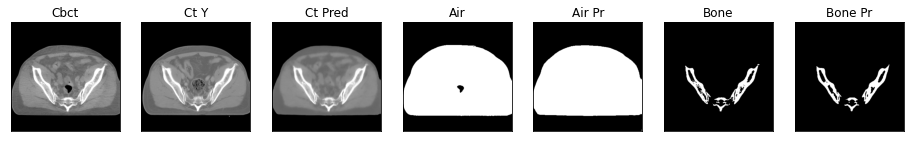

ssim score = 0.8768353462219238
psnr score = 26.234676361083984
snr score = 18.32514190673828
mae error = 0.021493863314390182
air dice score = 0.9952387875263531
bone dice score = 0.9584542430465111


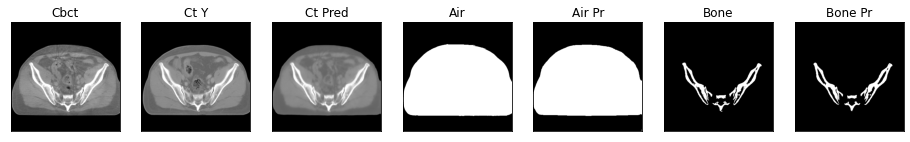

ssim score = 0.8228310346603394
psnr score = 21.17505645751953
snr score = 11.055264472961426
mae error = 0.03171447291970253
air dice score = 0.9940532974332053
bone dice score = 0.9638752052555042


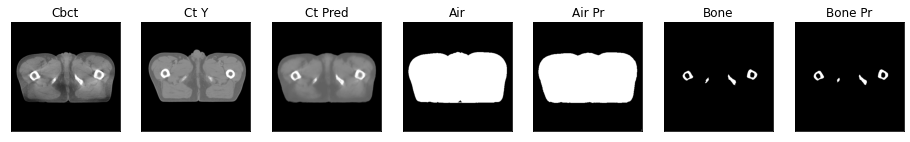

7it [00:15,  2.21s/it]

ssim score = 0.8117139935493469
psnr score = 20.819129943847656
snr score = 10.91231918334961
mae error = 0.03421597555279732
air dice score = 0.9942202680660998
bone dice score = 0.9353832442082134


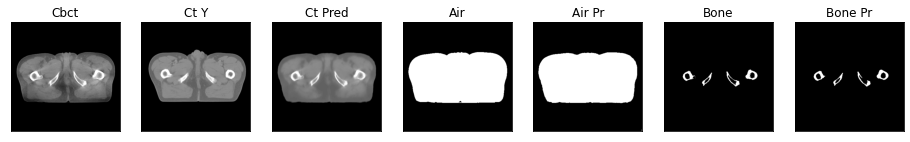

ssim score = 0.806122362613678
psnr score = 20.833585739135742
snr score = 11.05791187286377
mae error = 0.0346679762005806
air dice score = 0.9947543353875226
bone dice score = 0.9056847545239948


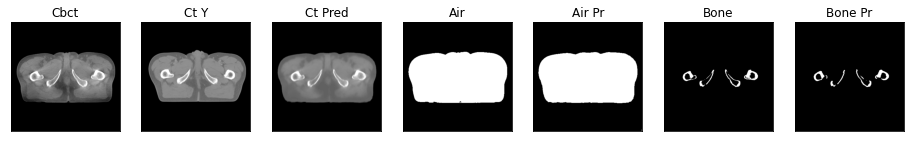

ssim score = 0.8092294335365295
psnr score = 21.1641902923584
snr score = 11.458921432495117
mae error = 0.03369657322764397
air dice score = 0.9937691154948394
bone dice score = 0.8985017936294893


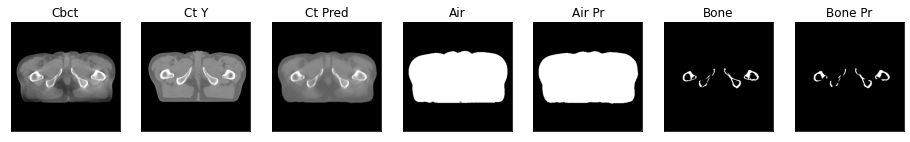

ssim score = 0.8077461123466492
psnr score = 21.14981460571289
snr score = 11.492111206054688
mae error = 0.03407735750079155
air dice score = 0.993594554498653
bone dice score = 0.8968883465548732


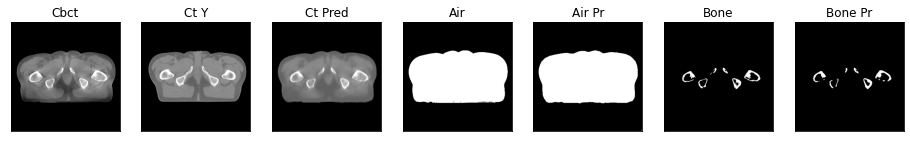

ssim score = 0.8118575811386108
psnr score = 21.35738754272461
snr score = 11.705299377441406
mae error = 0.033015478402376175
air dice score = 0.992811146643901
bone dice score = 0.9077132310101474


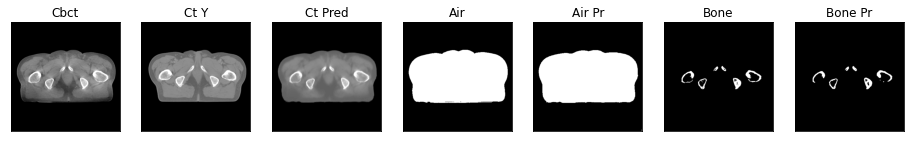

ssim score = 0.8145978450775146
psnr score = 21.426464080810547
snr score = 11.767871856689453
mae error = 0.03252555429935455
air dice score = 0.992671413295784
bone dice score = 0.9272341246877585


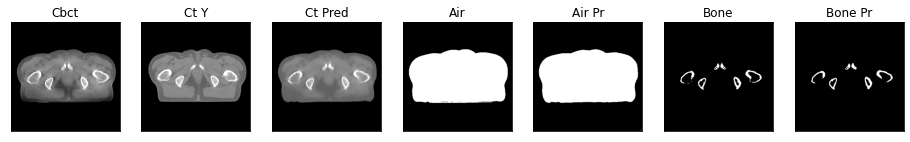

ssim score = 0.8154199719429016
psnr score = 21.332149505615234
snr score = 11.68766975402832
mae error = 0.0326068252325058
air dice score = 0.9930800342967071
bone dice score = 0.9374068554408084


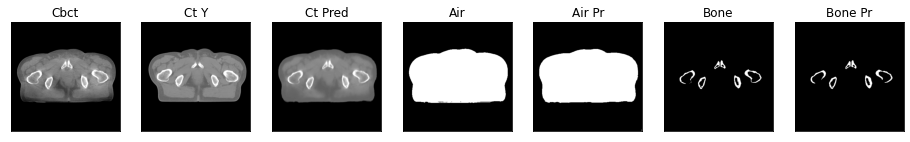

ssim score = 0.813725471496582
psnr score = 21.24620246887207
snr score = 11.65972900390625
mae error = 0.033531177788972855
air dice score = 0.9932957897559725
bone dice score = 0.9152199561787423


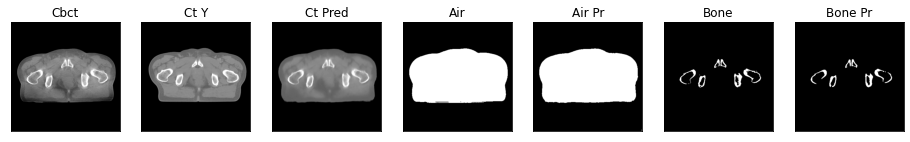

8it [00:17,  2.22s/it]

ssim score = 0.8064389228820801
psnr score = 21.083171844482422
snr score = 11.595258712768555
mae error = 0.035212624818086624
air dice score = 0.9929285960676156
bone dice score = 0.868764646805009


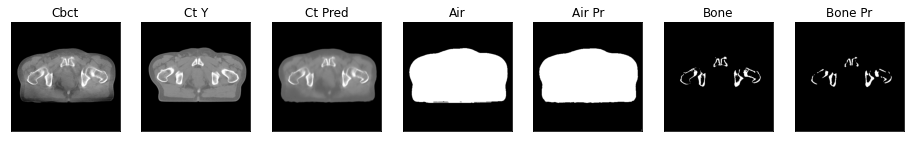

ssim score = 0.7962143421173096
psnr score = 20.966045379638672
snr score = 11.513961791992188
mae error = 0.03633152320981026
air dice score = 0.9933085886030768
bone dice score = 0.8657857029156856


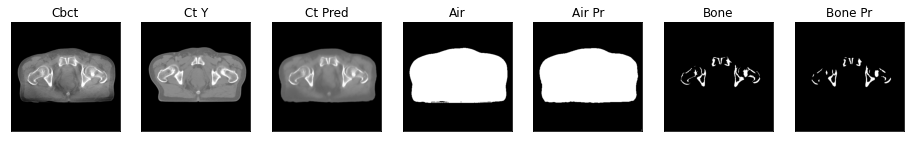

ssim score = 0.7843536734580994
psnr score = 20.80152702331543
snr score = 11.382149696350098
mae error = 0.036805618554353714
air dice score = 0.9938460214313433
bone dice score = 0.8528621908148005


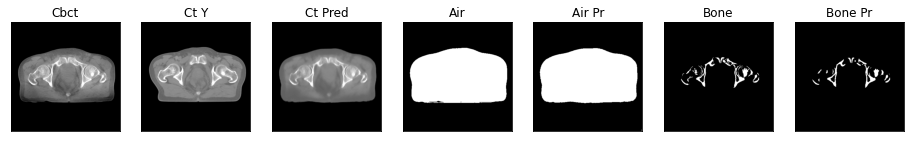

ssim score = 0.7855545282363892
psnr score = 20.823049545288086
snr score = 11.520488739013672
mae error = 0.03717871010303497
air dice score = 0.9944678178423677
bone dice score = 0.8504659498229323


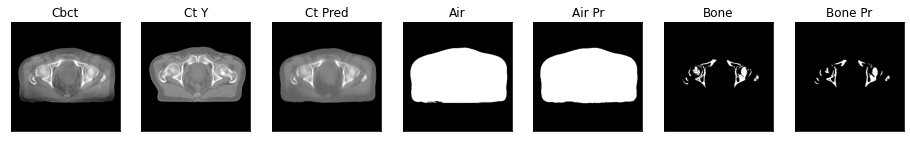

ssim score = 0.7883375883102417
psnr score = 20.73808479309082
snr score = 11.419535636901855
mae error = 0.037464357912540436
air dice score = 0.9945376813962937
bone dice score = 0.8356492573097645


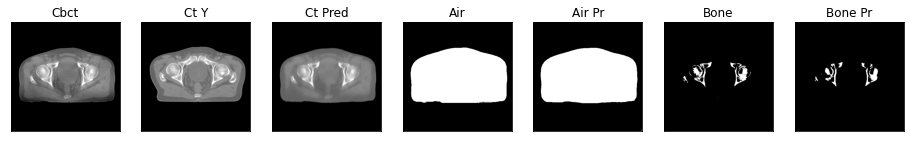

ssim score = 0.8035020232200623
psnr score = 21.256702423095703
snr score = 11.738990783691406
mae error = 0.03426926210522652
air dice score = 0.9942256135285675
bone dice score = 0.8834805800986251


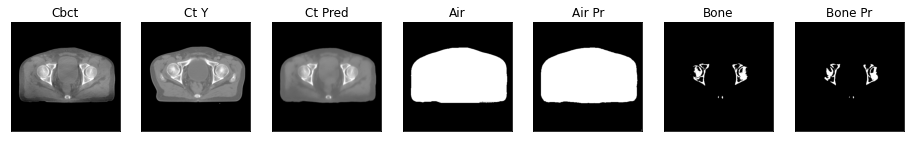

ssim score = 0.8183884620666504
psnr score = 21.972244262695312
snr score = 12.284140586853027
mae error = 0.031015532091259956
air dice score = 0.993584795622572
bone dice score = 0.9168290124394302


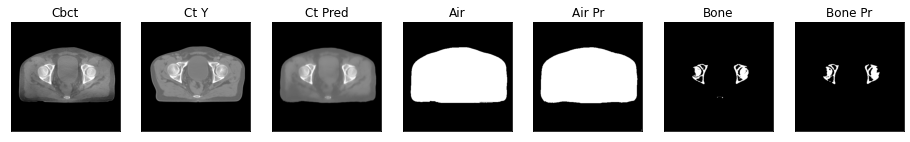

ssim score = 0.8246936798095703
psnr score = 22.321014404296875
snr score = 12.647079467773438
mae error = 0.029627999290823936
air dice score = 0.9929647381033953
bone dice score = 0.9418604651170651


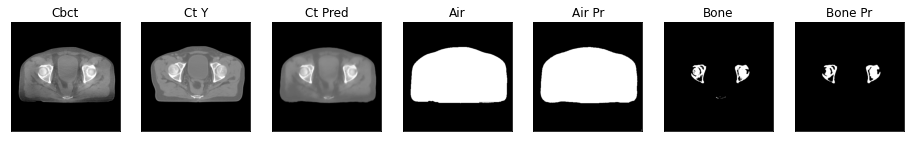

9it [00:20,  2.23s/it]

ssim score = 0.8296024203300476
psnr score = 22.514734268188477
snr score = 12.922626495361328
mae error = 0.029268397018313408
air dice score = 0.993409145237857
bone dice score = 0.9589964931216752


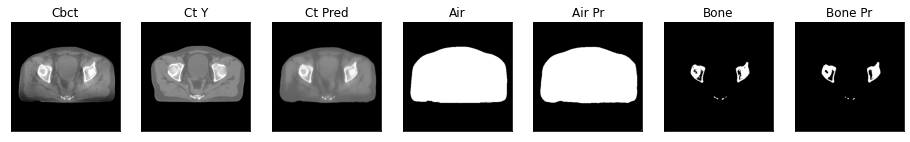

ssim score = 0.8300571441650391
psnr score = 22.548465728759766
snr score = 13.048530578613281
mae error = 0.029364628717303276
air dice score = 0.9935772939452847
bone dice score = 0.9454990814460272


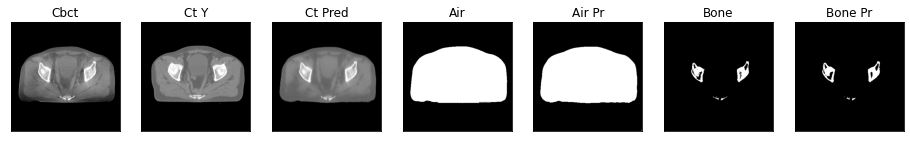

ssim score = 0.8284412026405334
psnr score = 22.865039825439453
snr score = 13.301679611206055
mae error = 0.028078218922019005
air dice score = 0.9935949711179123
bone dice score = 0.9534688392415006


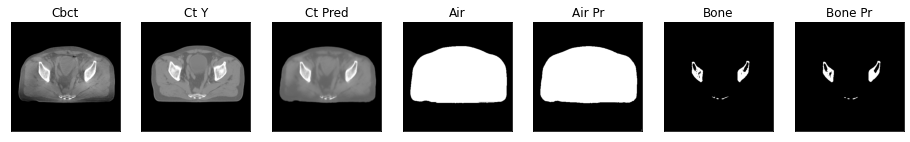

ssim score = 0.8331496119499207
psnr score = 23.210237503051758
snr score = 13.610483169555664
mae error = 0.026742706075310707
air dice score = 0.9928948127045557
bone dice score = 0.9594643503445627


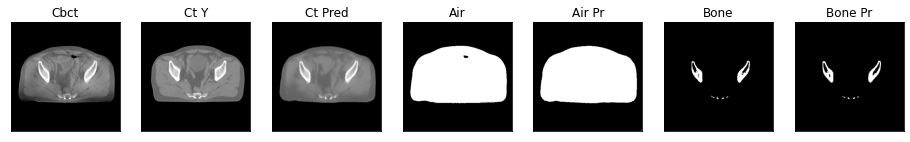

ssim score = 0.8303014636039734
psnr score = 23.087003707885742
snr score = 13.524993896484375
mae error = 0.02782522700726986
air dice score = 0.9927093930145874
bone dice score = 0.9289710120371424


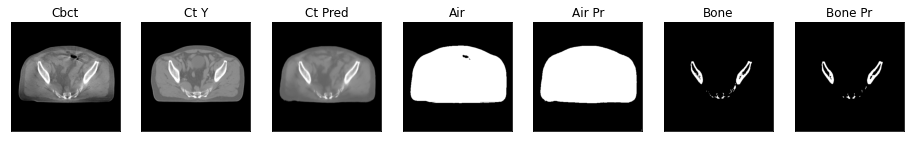

ssim score = 0.8243675231933594
psnr score = 22.870845794677734
snr score = 13.43934154510498
mae error = 0.028833717107772827
air dice score = 0.9936277591802803
bone dice score = 0.9306988231885704


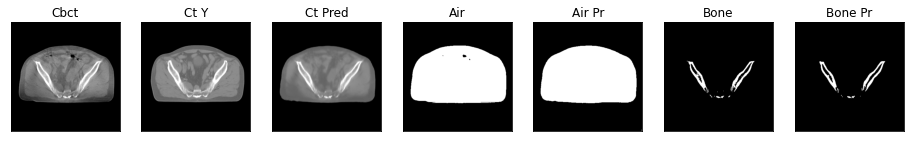

ssim score = 0.8269755840301514
psnr score = 22.85501480102539
snr score = 13.44125747680664
mae error = 0.028793811798095703
air dice score = 0.9933034762209484
bone dice score = 0.9143307086627664


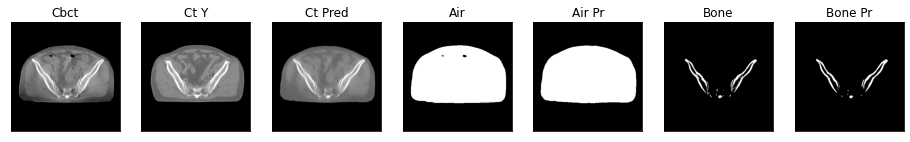

ssim score = 0.8305840492248535
psnr score = 23.153453826904297
snr score = 13.728426933288574
mae error = 0.028068700805306435
air dice score = 0.9937213730636666
bone dice score = 0.9277862337235281


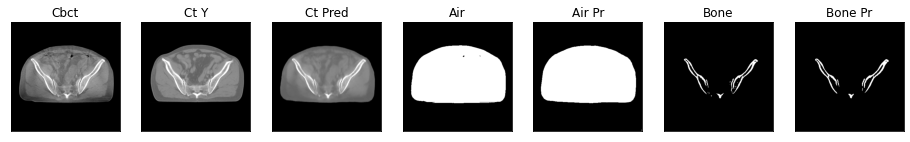

10it [00:22,  2.18s/it]

ssim score = 0.8346275687217712
psnr score = 23.327579498291016
snr score = 13.901813507080078
mae error = 0.027475623413920403
air dice score = 0.9929190427786357
bone dice score = 0.8954628552452142


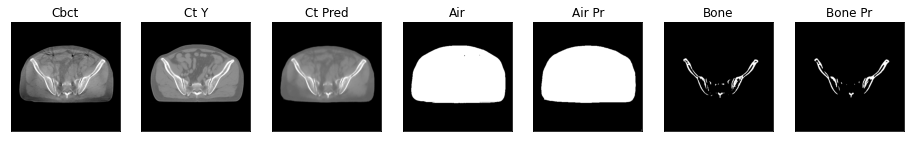

ssim score = 0.8827191591262817
psnr score = 24.608226776123047
snr score = 15.0423583984375
mae error = 0.018826793879270554
air dice score = 0.9930223491689729
bone dice score = 0.9627066512894


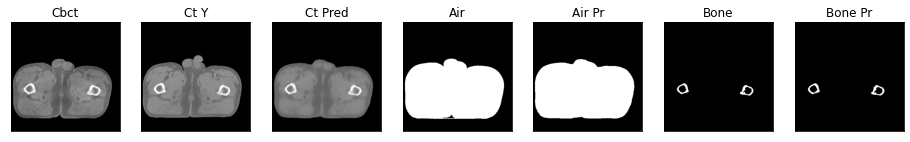

ssim score = 0.8817196488380432
psnr score = 24.796674728393555
snr score = 15.295201301574707
mae error = 0.01878417655825615
air dice score = 0.9933503593652453
bone dice score = 0.9413854351708211


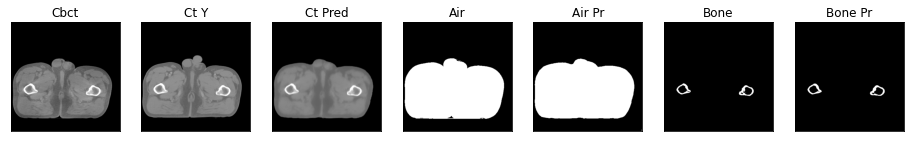

ssim score = 0.8915172815322876
psnr score = 26.832870483398438
snr score = 17.470611572265625
mae error = 0.017197271808981895
air dice score = 0.9928745546596718
bone dice score = 0.9461132767726184


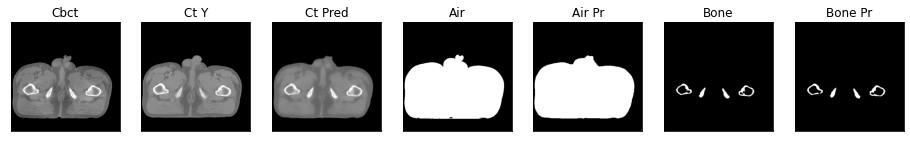

ssim score = 0.891796350479126
psnr score = 26.775314331054688
snr score = 17.5345458984375
mae error = 0.017693715170025826
air dice score = 0.9939918699818948
bone dice score = 0.9378881987591418


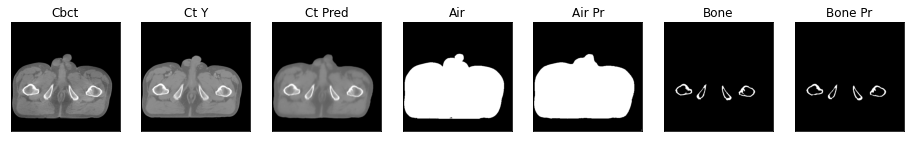

ssim score = 0.8878427743911743
psnr score = 26.568099975585938
snr score = 17.351505279541016
mae error = 0.017956197261810303
air dice score = 0.9944261405480875
bone dice score = 0.9150899861579351


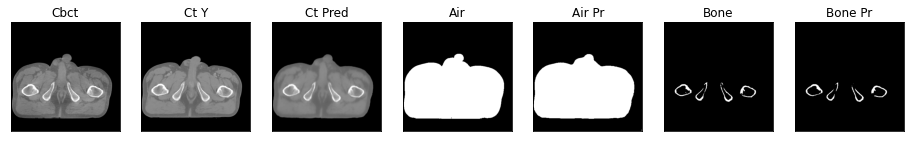

ssim score = 0.8869528770446777
psnr score = 26.301115036010742
snr score = 17.080121994018555
mae error = 0.018217826262116432
air dice score = 0.9955089588527748
bone dice score = 0.9056603773604905


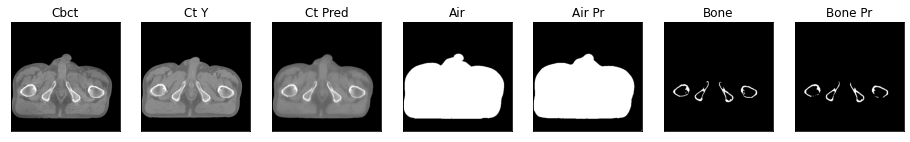

ssim score = 0.8889943957328796
psnr score = 25.884130477905273
snr score = 16.669391632080078
mae error = 0.01861446164548397
air dice score = 0.994774935170496
bone dice score = 0.8958333333355035


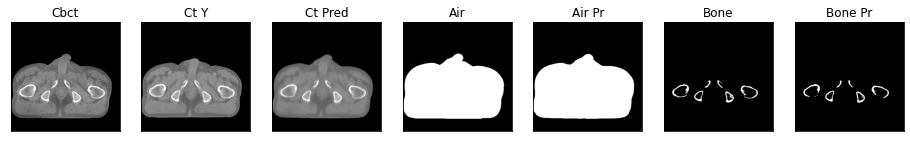

11it [00:24,  2.20s/it]

ssim score = 0.888306736946106
psnr score = 25.60601043701172
snr score = 16.369714736938477
mae error = 0.01845332235097885
air dice score = 0.9954596872917767
bone dice score = 0.9196428571444878


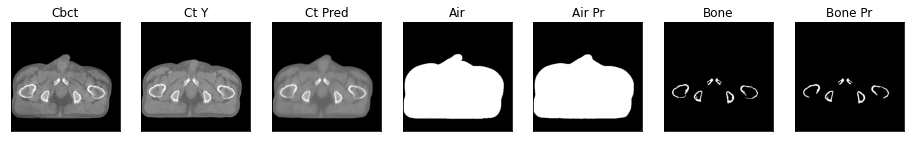

ssim score = 0.8898736238479614
psnr score = 25.674022674560547
snr score = 16.45463752746582
mae error = 0.018184803426265717
air dice score = 0.995819735819739
bone dice score = 0.9336840127759969


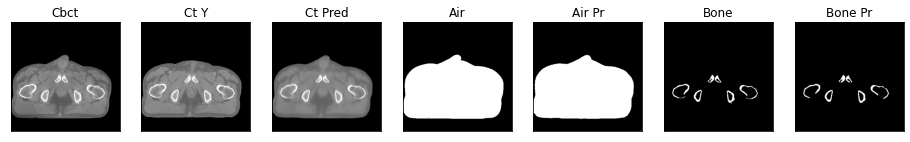

ssim score = 0.8907758593559265
psnr score = 26.03997039794922
snr score = 16.889179229736328
mae error = 0.018092714250087738
air dice score = 0.9961695388624107
bone dice score = 0.9225984796143297


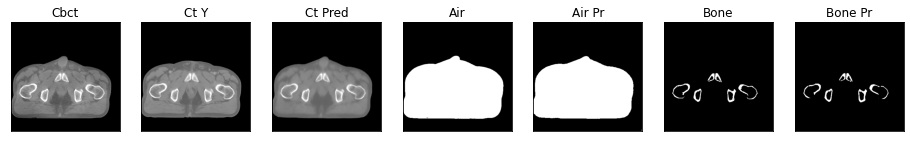

ssim score = 0.8923432230949402
psnr score = 26.589582443237305
snr score = 17.52014923095703
mae error = 0.017659613862633705
air dice score = 0.9965531828223193
bone dice score = 0.9053683701450045


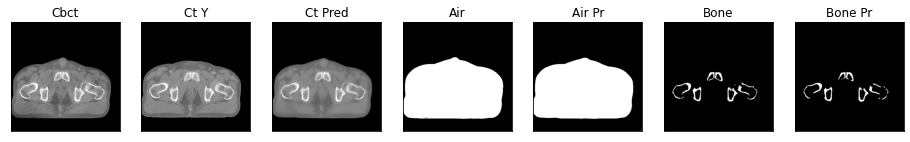

ssim score = 0.8941227197647095
psnr score = 27.20344352722168
snr score = 18.184711456298828
mae error = 0.017173347994685173
air dice score = 0.9962647542208307
bone dice score = 0.8631545641534069


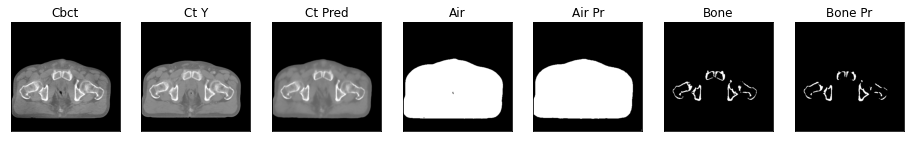

ssim score = 0.8965215682983398
psnr score = 27.49334716796875
snr score = 18.59088897705078
mae error = 0.017044981941580772
air dice score = 0.9968992859678907
bone dice score = 0.8375000000024182


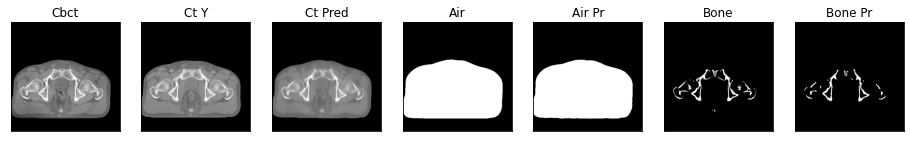

ssim score = 0.896761417388916
psnr score = 27.849029541015625
snr score = 18.90833282470703
mae error = 0.01665118709206581
air dice score = 0.9952957202141514
bone dice score = 0.8315571814882844


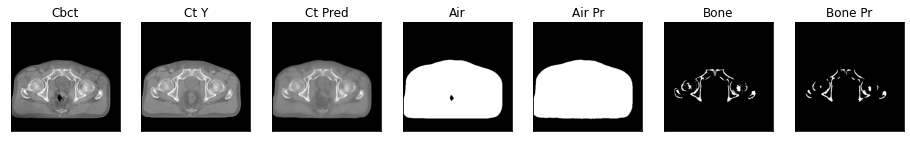

ssim score = 0.8955256938934326
psnr score = 28.118478775024414
snr score = 19.08211326599121
mae error = 0.015993090346455574
air dice score = 0.9921010051092451
bone dice score = 0.819319687824778


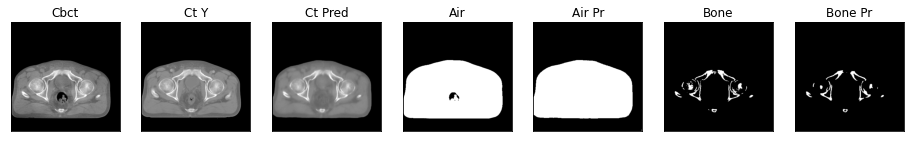

12it [00:26,  2.15s/it]

ssim score = 0.9000210762023926
psnr score = 28.364139556884766
snr score = 19.168010711669922
mae error = 0.015170854516327381
air dice score = 0.9897710511126869
bone dice score = 0.8324742268072077


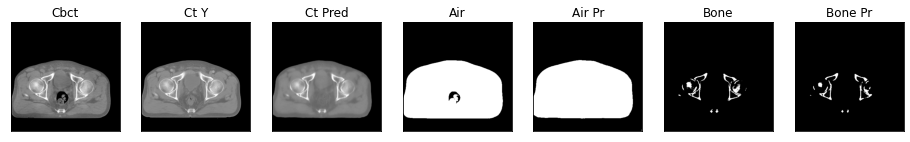

ssim score = 0.89677894115448
psnr score = 27.80982208251953
snr score = 18.497270584106445
mae error = 0.015553610399365425
air dice score = 0.9872575461490114
bone dice score = 0.8419664720316073


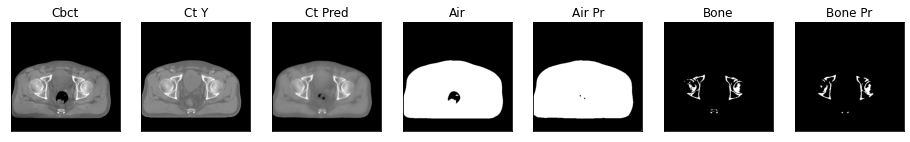

ssim score = 0.8920769691467285
psnr score = 26.786842346191406
snr score = 17.429197311401367
mae error = 0.016492033377289772
air dice score = 0.9876177131871455
bone dice score = 0.8615170494108991


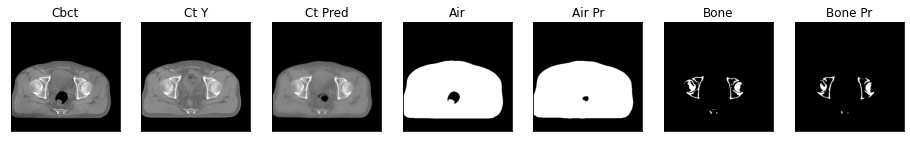

ssim score = 0.8835842609405518
psnr score = 25.62857437133789
snr score = 16.277603149414062
mae error = 0.018520118668675423
air dice score = 0.9895680282104111
bone dice score = 0.9094849141538676


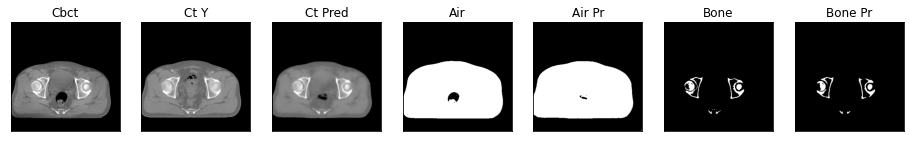

ssim score = 0.8843469023704529
psnr score = 24.520862579345703
snr score = 15.199993133544922
mae error = 0.02036665938794613
air dice score = 0.9928969690997685
bone dice score = 0.9419981779541148


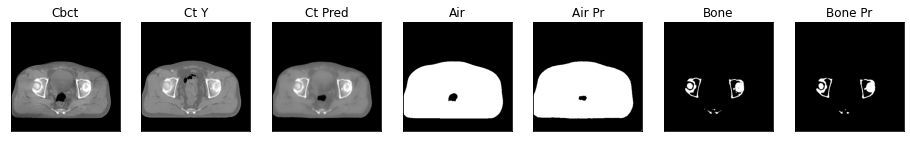

ssim score = 0.8873045444488525
psnr score = 25.027706146240234
snr score = 15.664253234863281
mae error = 0.019312545657157898
air dice score = 0.9926068312878961
bone dice score = 0.9269382843402624


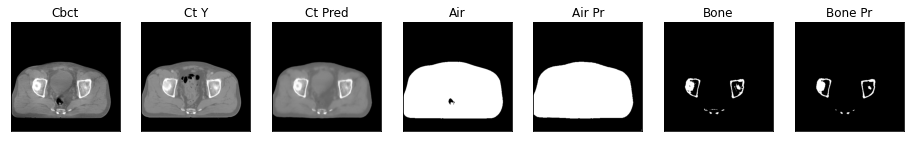

ssim score = 0.8894282579421997
psnr score = 25.022686004638672
snr score = 15.569026947021484
mae error = 0.01859164796769619
air dice score = 0.9941873906007512
bone dice score = 0.9111418959051822


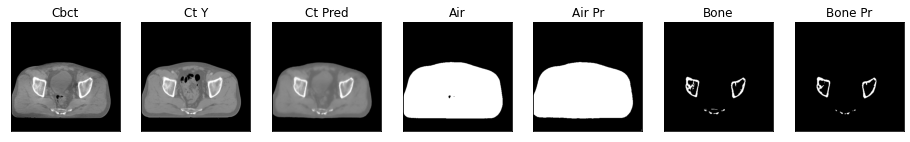

ssim score = 0.8883327841758728
psnr score = 24.946792602539062
snr score = 15.427408218383789
mae error = 0.018691547214984894
air dice score = 0.9923274935645979
bone dice score = 0.9343768813980659


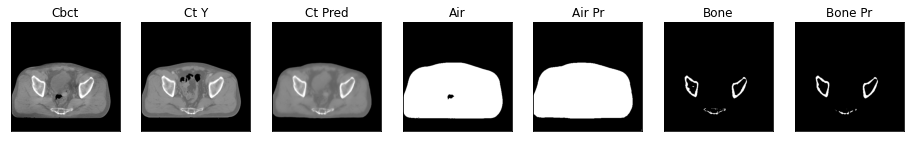

13it [00:28,  2.18s/it]

ssim score = 0.8889129757881165
psnr score = 25.315502166748047
snr score = 15.795814514160156
mae error = 0.018304774537682533
air dice score = 0.9921504167994565
bone dice score = 0.9339922343816803


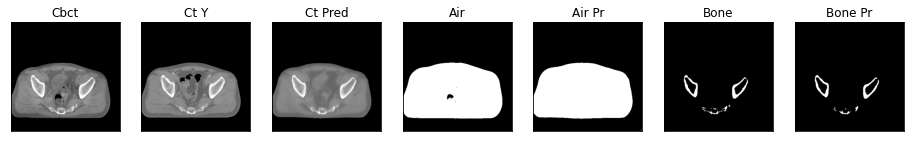

ssim score = 0.8841447234153748
psnr score = 25.373380661010742
snr score = 15.92986011505127
mae error = 0.01900961622595787
air dice score = 0.991534033186597
bone dice score = 0.9206442166922307


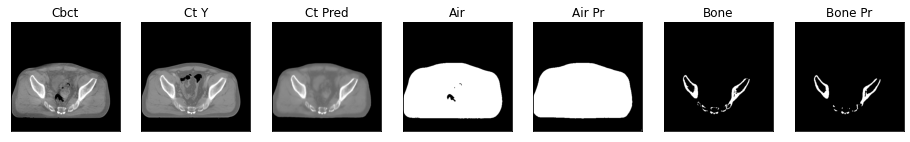

ssim score = 0.8893041610717773
psnr score = 25.60112190246582
snr score = 16.19318389892578
mae error = 0.018411004915833473
air dice score = 0.9923393522108576
bone dice score = 0.9310206804545561


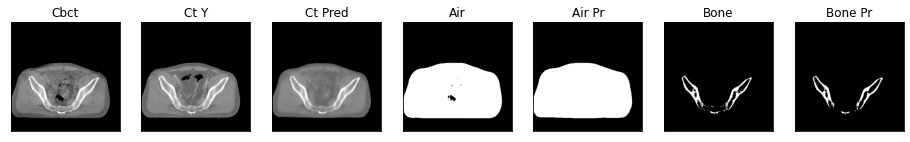

ssim score = 0.8903458118438721
psnr score = 25.696868896484375
snr score = 16.227231979370117
mae error = 0.017973685637116432
air dice score = 0.9929003734386462
bone dice score = 0.9091426133952916


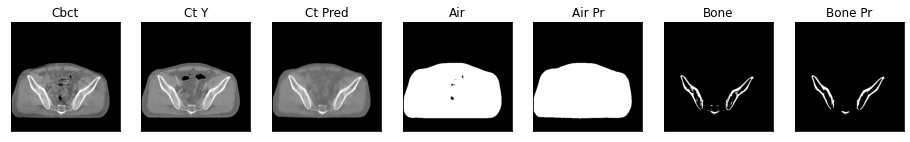

ssim score = 0.8880599737167358
psnr score = 25.317981719970703
snr score = 15.787084579467773
mae error = 0.018497996032238007
air dice score = 0.9926455938531434
bone dice score = 0.905801435408107


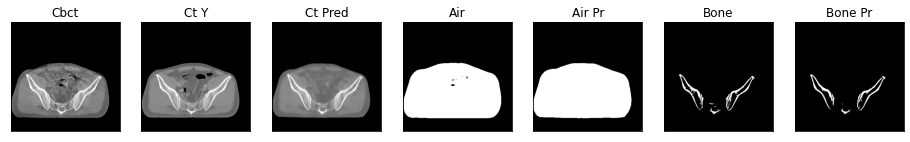

ssim score = 0.8300726413726807
psnr score = 23.07114028930664
snr score = 14.768446922302246
mae error = 0.02742595225572586
air dice score = 0.9932252930282685
bone dice score = 0.9718397997505682


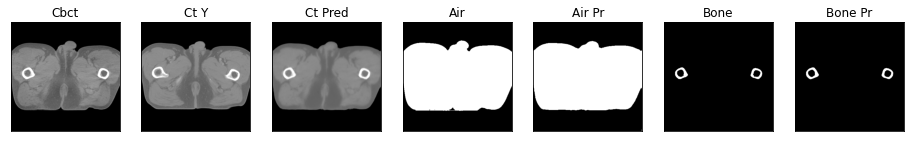

ssim score = 0.8206741809844971
psnr score = 22.67626953125
snr score = 14.477867126464844
mae error = 0.02899075299501419
air dice score = 0.9943147710018042
bone dice score = 0.9671574178944746


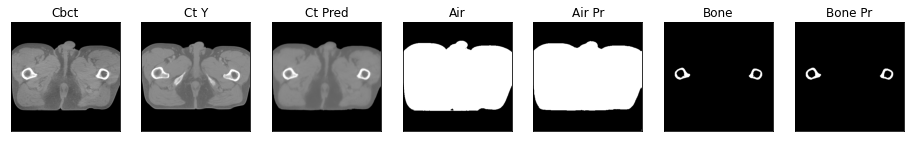

ssim score = 0.8126614093780518
psnr score = 22.24419403076172
snr score = 14.173747062683105
mae error = 0.031479526311159134
air dice score = 0.9953471998122478
bone dice score = 0.9421525697178578


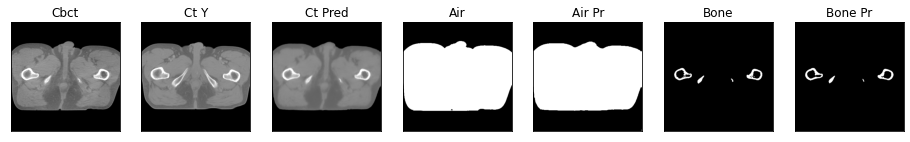

14it [00:30,  2.14s/it]

ssim score = 0.8025957942008972
psnr score = 21.81722640991211
snr score = 13.779069900512695
mae error = 0.03226683661341667
air dice score = 0.995534434020241
bone dice score = 0.9532173619328962


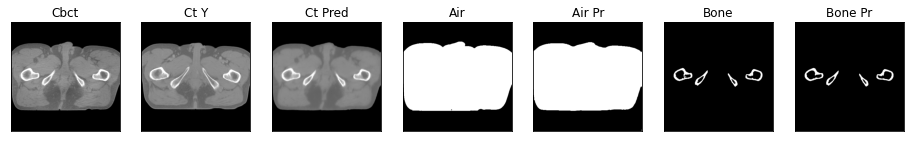

ssim score = 0.7935380339622498
psnr score = 21.655715942382812
snr score = 13.647796630859375
mae error = 0.03322587534785271
air dice score = 0.9956574016786736
bone dice score = 0.9270885235022905


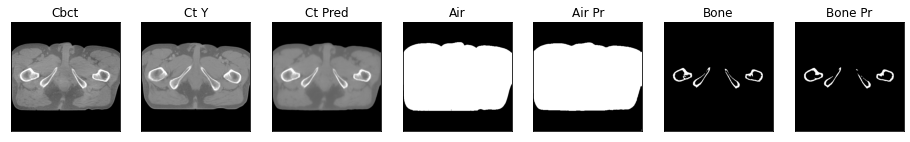

ssim score = 0.7861889600753784
psnr score = 21.526071548461914
snr score = 13.552570343017578
mae error = 0.034111324697732925
air dice score = 0.9954012015088742
bone dice score = 0.9302760879748826


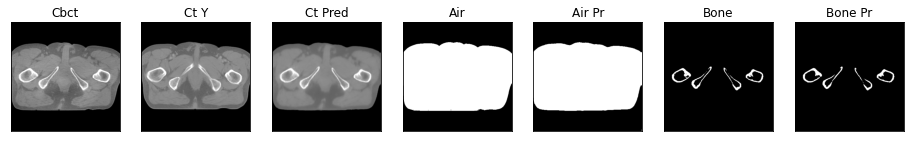

ssim score = 0.7790763974189758
psnr score = 21.266109466552734
snr score = 13.312917709350586
mae error = 0.03537445142865181
air dice score = 0.9956393663164268
bone dice score = 0.9270588235304213


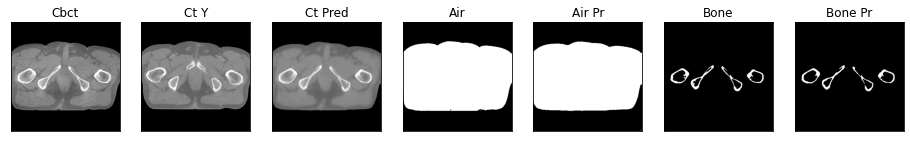

ssim score = 0.777789294719696
psnr score = 21.2979736328125
snr score = 13.383856773376465
mae error = 0.034987855702638626
air dice score = 0.9949511909862576
bone dice score = 0.9191877331134247


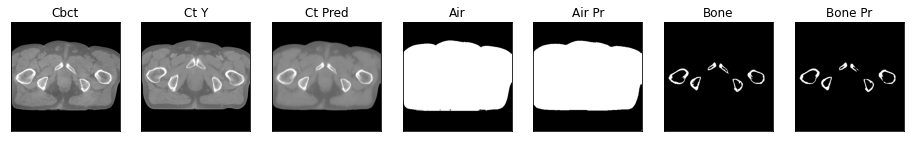

ssim score = 0.7799837589263916
psnr score = 21.472360610961914
snr score = 13.606922149658203
mae error = 0.03474966809153557
air dice score = 0.9945390001100339
bone dice score = 0.9270819497950978


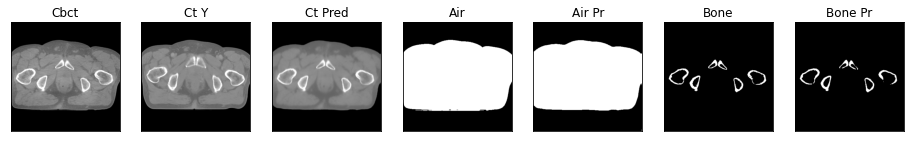

ssim score = 0.7703386545181274
psnr score = 21.249069213867188
snr score = 13.406243324279785
mae error = 0.03643544390797615
air dice score = 0.9946543245588692
bone dice score = 0.9289281598165076


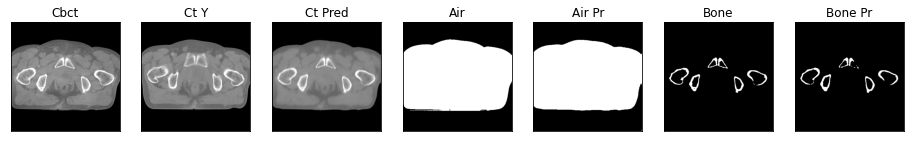

ssim score = 0.7578657269477844
psnr score = 21.17946434020996
snr score = 13.379413604736328
mae error = 0.037976715713739395
air dice score = 0.9955393981361288
bone dice score = 0.9069200779738434


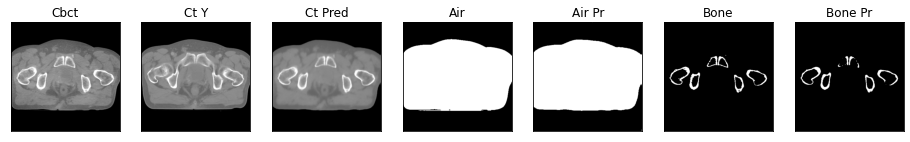

15it [00:33,  2.19s/it]

ssim score = 0.7595103979110718
psnr score = 21.238056182861328
snr score = 13.496343612670898
mae error = 0.037937816232442856
air dice score = 0.9952659522453678
bone dice score = 0.9018994413418782


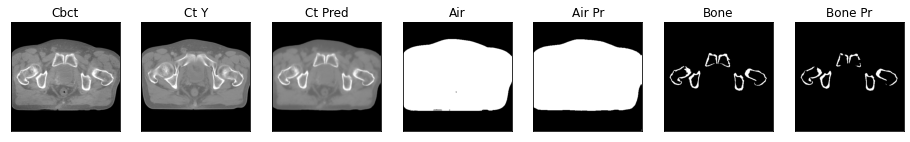

ssim score = 0.754562497138977
psnr score = 20.99283218383789
snr score = 13.17574691772461
mae error = 0.040135715156793594
air dice score = 0.9961606547578016
bone dice score = 0.8896855474762912


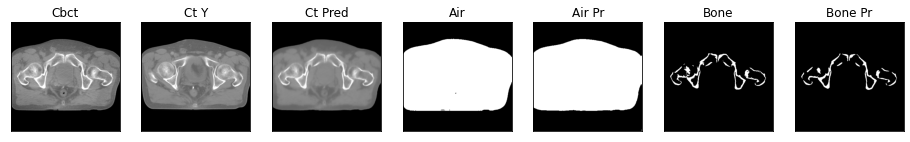

ssim score = 0.7583985924720764
psnr score = 20.796720504760742
snr score = 12.872420310974121
mae error = 0.04118548706173897
air dice score = 0.9968519135540076
bone dice score = 0.8651993102762431


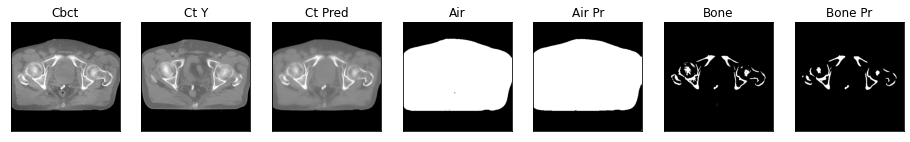

ssim score = 0.7697744965553284
psnr score = 21.02593421936035
snr score = 12.978545188903809
mae error = 0.04013310372829437
air dice score = 0.9966718208416461
bone dice score = 0.8275432956566675


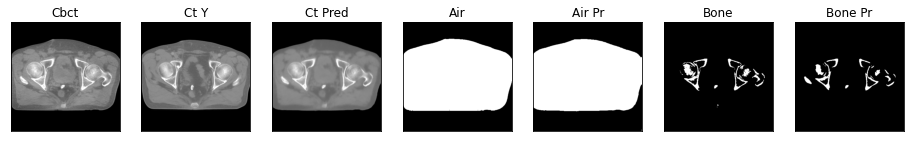

ssim score = 0.7726529836654663
psnr score = 21.23499298095703
snr score = 13.075174331665039
mae error = 0.03888527303934097
air dice score = 0.9962018385637323
bone dice score = 0.8713966599311627


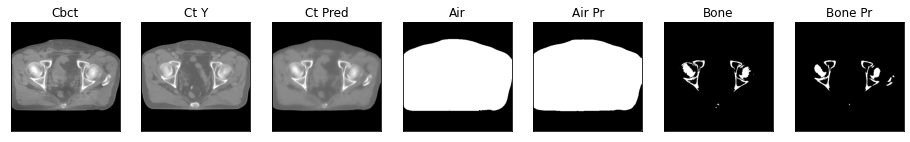

ssim score = 0.7719866037368774
psnr score = 21.538259506225586
snr score = 13.327796936035156
mae error = 0.03616107255220413
air dice score = 0.9962966600611275
bone dice score = 0.895343870142083


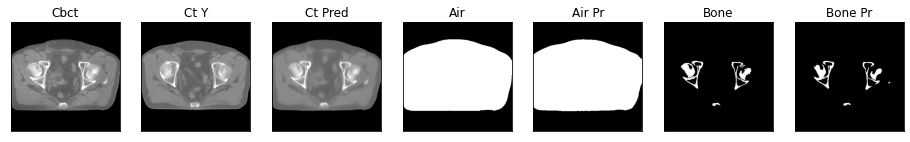

ssim score = 0.771040141582489
psnr score = 21.407793045043945
snr score = 13.229484558105469
mae error = 0.03709281235933304
air dice score = 0.996381811645466
bone dice score = 0.896364867917178


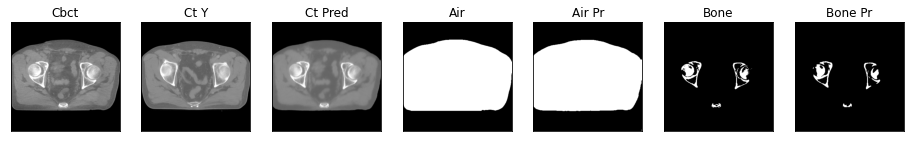

ssim score = 0.771635890007019
psnr score = 21.242034912109375
snr score = 13.077200889587402
mae error = 0.037755224853754044
air dice score = 0.9958239902152096
bone dice score = 0.9069484936843178


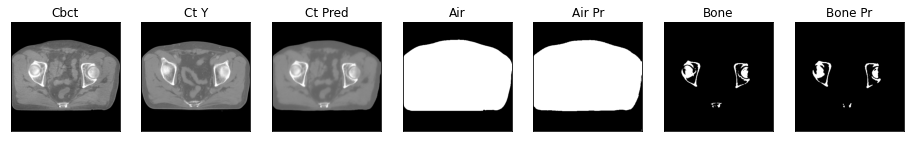

16it [00:35,  2.21s/it]

ssim score = 0.7686811089515686
psnr score = 20.82939910888672
snr score = 12.5230712890625
mae error = 0.03967801108956337
air dice score = 0.9956760109299235
bone dice score = 0.9318639649255614


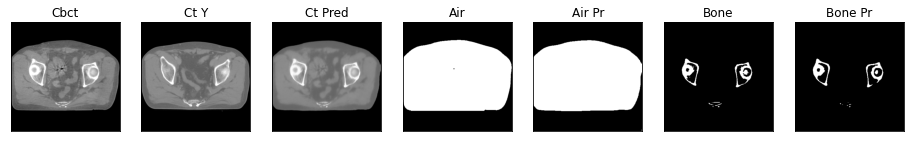

ssim score = 0.7788205146789551
psnr score = 21.003925323486328
snr score = 12.638291358947754
mae error = 0.038291558623313904
air dice score = 0.9959621881879314
bone dice score = 0.9233775296591294


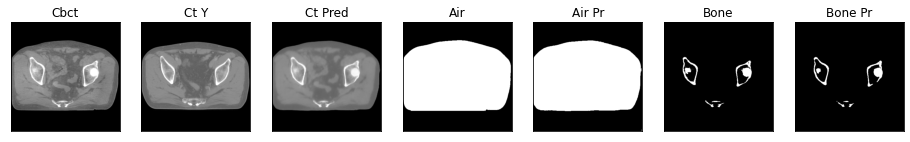

ssim score = 0.778362512588501
psnr score = 21.316551208496094
snr score = 12.97656536102295
mae error = 0.03628825768828392
air dice score = 0.9960419587866763
bone dice score = 0.9119130772232845


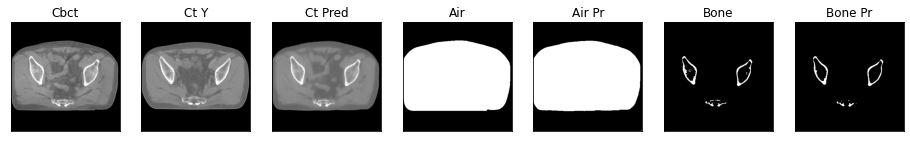

ssim score = 0.7746654152870178
psnr score = 21.315216064453125
snr score = 13.048046112060547
mae error = 0.03628236800432205
air dice score = 0.9957140224582871
bone dice score = 0.9186151894160121


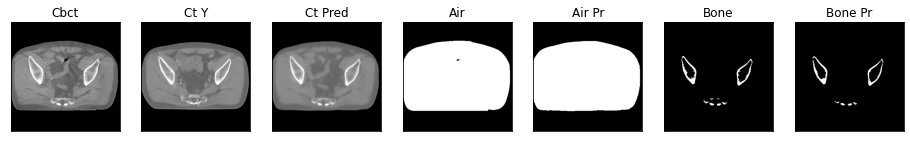

ssim score = 0.7690406441688538
psnr score = 21.089448928833008
snr score = 12.951508522033691
mae error = 0.03780481591820717
air dice score = 0.9952886593007155
bone dice score = 0.9237458193992685


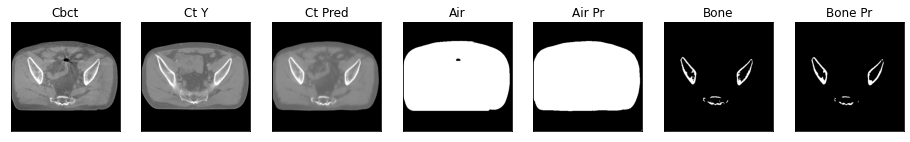

ssim score = 0.7615764141082764
psnr score = 20.97494888305664
snr score = 12.870967864990234
mae error = 0.03833448886871338
air dice score = 0.9947045423125734
bone dice score = 0.9248257047601572


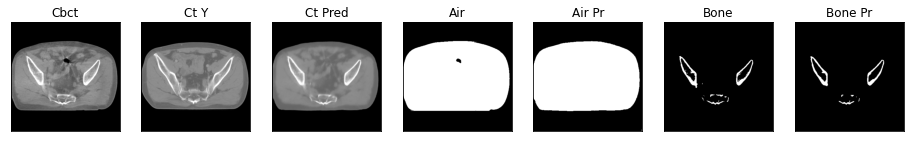

ssim score = 0.7498549818992615
psnr score = 20.820636749267578
snr score = 12.68686294555664
mae error = 0.039462827146053314
air dice score = 0.9953746977271521
bone dice score = 0.9121098626727577


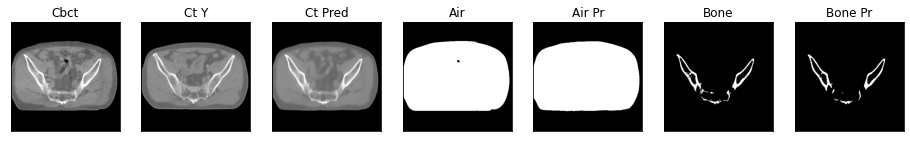

ssim score = 0.7481610774993896
psnr score = 20.993680953979492
snr score = 12.796531677246094
mae error = 0.03846168890595436
air dice score = 0.9957801308946511
bone dice score = 0.9043106899785892


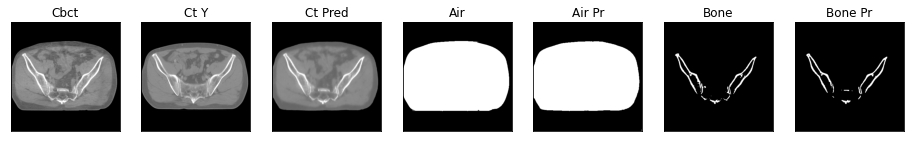

17it [00:37,  2.16s/it]

ssim score = 0.8595852255821228
psnr score = 24.061813354492188
snr score = 15.539203643798828
mae error = 0.024541040882468224
air dice score = 0.9966430768090728
bone dice score = 0.8922575795553463


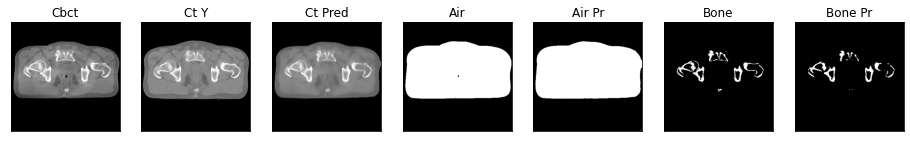

ssim score = 0.8625955581665039
psnr score = 24.472925186157227
snr score = 15.99032974243164
mae error = 0.023331739008426666
air dice score = 0.996090765453348
bone dice score = 0.8804916318007258


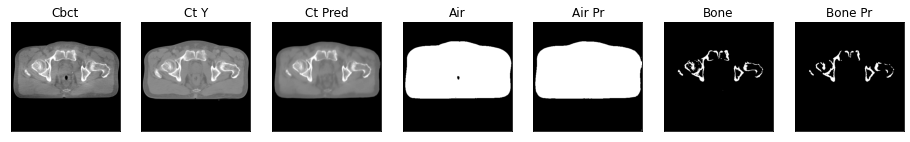

ssim score = 0.8620960116386414
psnr score = 24.506488800048828
snr score = 16.03167724609375
mae error = 0.023769447579979897
air dice score = 0.9971399493362475
bone dice score = 0.84551031790511


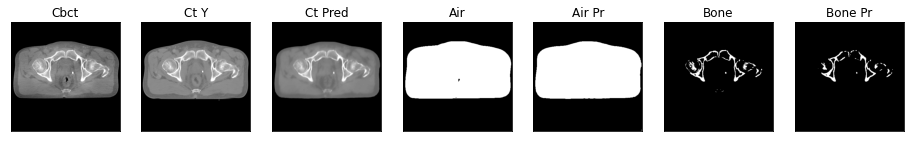

ssim score = 0.865676999092102
psnr score = 24.610809326171875
snr score = 16.077579498291016
mae error = 0.022836411371827126
air dice score = 0.9964237285610005
bone dice score = 0.8522327821917428


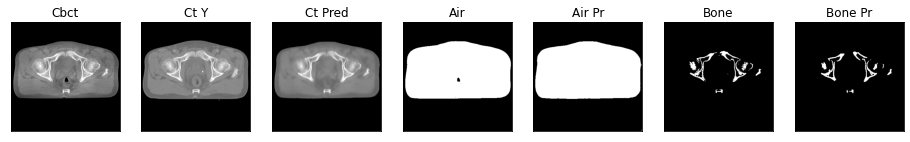

ssim score = 0.8698203563690186
psnr score = 24.7093505859375
snr score = 16.02050018310547
mae error = 0.021354826167225838
air dice score = 0.9958219039860113
bone dice score = 0.858167082296475


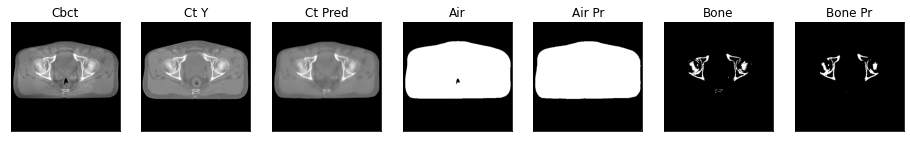

ssim score = 0.8726292252540588
psnr score = 24.728906631469727
snr score = 16.019248962402344
mae error = 0.021140893921256065
air dice score = 0.9959678023773507
bone dice score = 0.8828724482426108


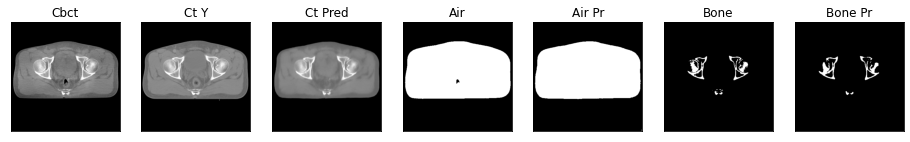

ssim score = 0.8727160096168518
psnr score = 24.744081497192383
snr score = 16.0187931060791
mae error = 0.021018704399466515
air dice score = 0.9964957663443199
bone dice score = 0.8940472799787234


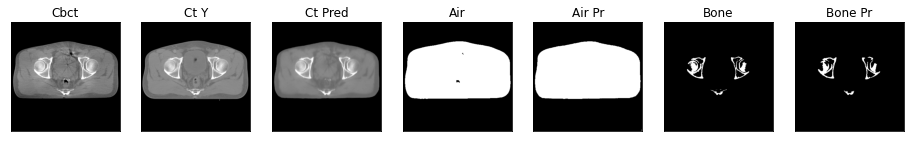

ssim score = 0.8679722547531128
psnr score = 24.185379028320312
snr score = 15.469456672668457
mae error = 0.021971320733428
air dice score = 0.9951741169540331
bone dice score = 0.8906538079720514


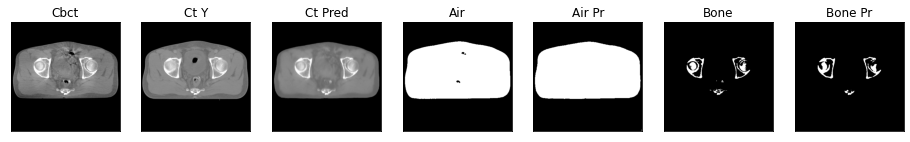

18it [00:39,  2.19s/it]

ssim score = 0.8667088747024536
psnr score = 24.1274471282959
snr score = 15.467304229736328
mae error = 0.022725548595190048
air dice score = 0.9955719054431534
bone dice score = 0.9197846196338564


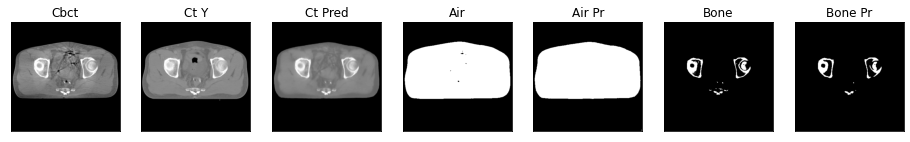

ssim score = 0.8647108674049377
psnr score = 23.61941909790039
snr score = 14.937347412109375
mae error = 0.02374076656997204
air dice score = 0.9950229098120902
bone dice score = 0.9234910739597125


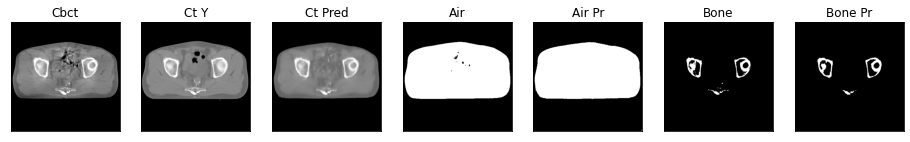

ssim score = 0.8632849454879761
psnr score = 23.173789978027344
snr score = 14.42094612121582
mae error = 0.023839889094233513
air dice score = 0.9946938277628731
bone dice score = 0.8938439166279877


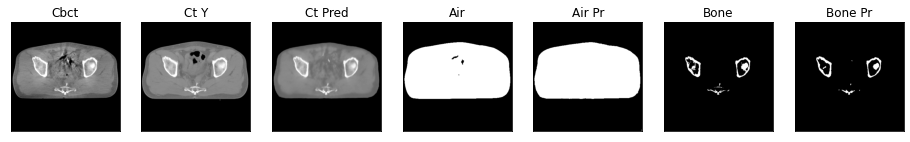

ssim score = 0.8642405867576599
psnr score = 23.415708541870117
snr score = 14.618968963623047
mae error = 0.02360682748258114
air dice score = 0.9958847108226793
bone dice score = 0.9001703577529784


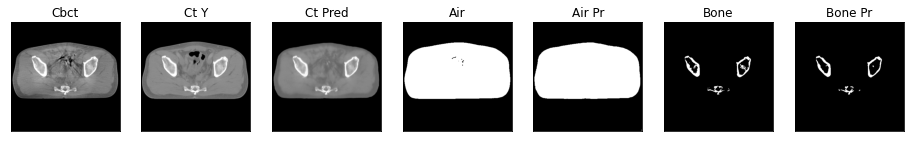

ssim score = 0.865319013595581
psnr score = 23.724775314331055
snr score = 14.9269380569458
mae error = 0.022960178554058075
air dice score = 0.9945681736345778
bone dice score = 0.9155555555569456


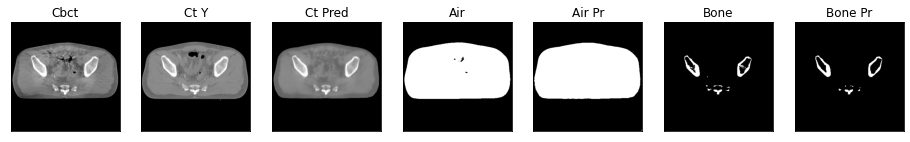

ssim score = 0.863899290561676
psnr score = 24.160499572753906
snr score = 15.376020431518555
mae error = 0.022466739639639854
air dice score = 0.9938874835654087
bone dice score = 0.9250743000168141


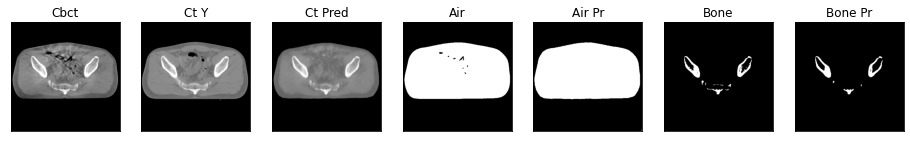

ssim score = 0.8615710139274597
psnr score = 24.309268951416016
snr score = 15.579994201660156
mae error = 0.022474631667137146
air dice score = 0.9921422727202617
bone dice score = 0.9351120321210321


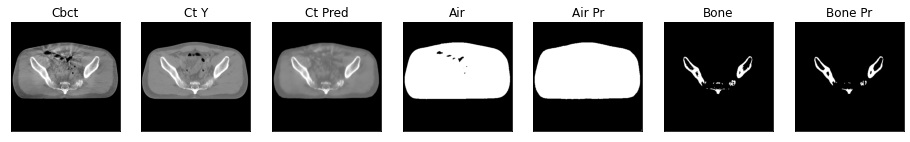

ssim score = 0.8628697395324707
psnr score = 23.943330764770508
snr score = 15.233427047729492
mae error = 0.02279472164809704
air dice score = 0.9926818901897201
bone dice score = 0.9278541226225178


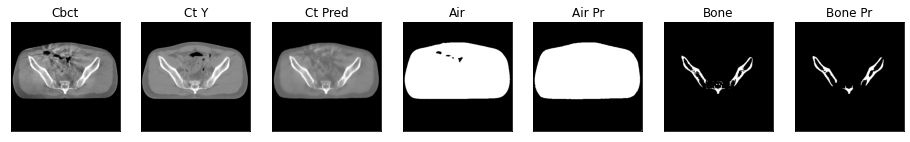

19it [00:41,  2.14s/it]

ssim score = 0.8638405799865723
psnr score = 23.431068420410156
snr score = 14.666425704956055
mae error = 0.02350454218685627
air dice score = 0.9933005322440948
bone dice score = 0.9126637554597865


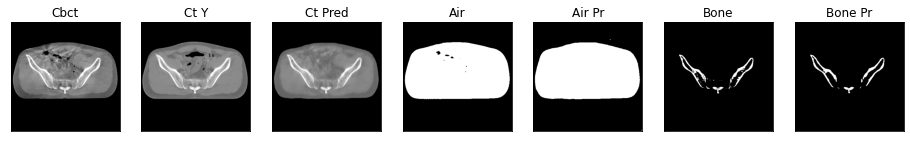

ssim score = 0.8637028336524963
psnr score = 23.32134437561035
snr score = 14.520349502563477
mae error = 0.02386193908751011
air dice score = 0.9943641036757236
bone dice score = 0.8932944606429549


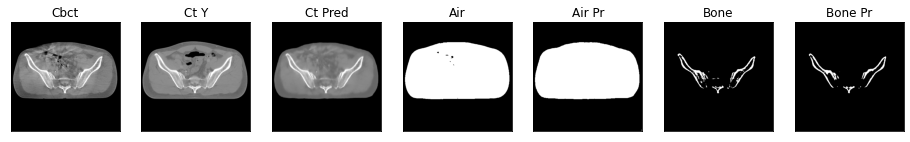

ssim score = 0.8684371709823608
psnr score = 23.474157333374023
snr score = 14.673232078552246
mae error = 0.023355498909950256
air dice score = 0.9947388403753363
bone dice score = 0.8933263268537398


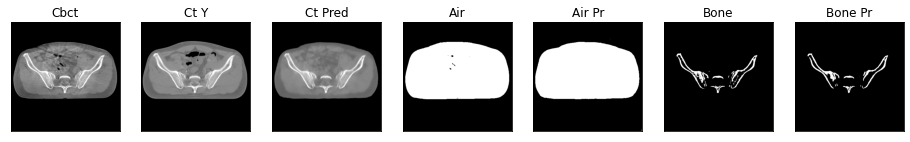

ssim score = 0.8707687258720398
psnr score = 23.92268180847168
snr score = 15.120335578918457
mae error = 0.02280966006219387
air dice score = 0.9946083489135283
bone dice score = 0.8849652220454125


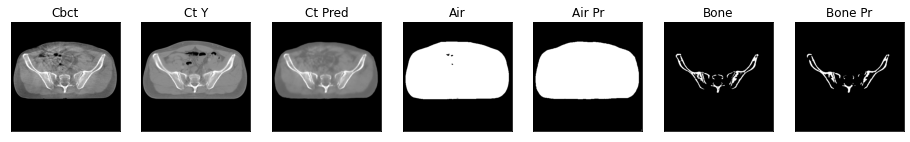

ssim score = 0.8636115193367004
psnr score = 23.63895034790039
snr score = 14.841641426086426
mae error = 0.02354031801223755
air dice score = 0.9929135389522049
bone dice score = 0.8771451920474375


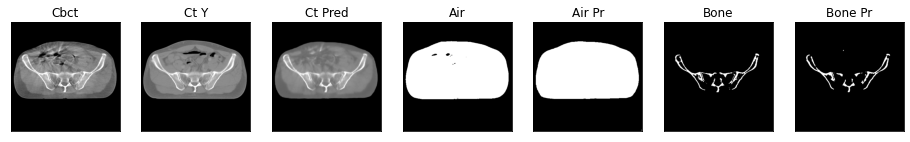

ssim score = 0.8629899621009827
psnr score = 23.532596588134766
snr score = 14.718017578125
mae error = 0.023886963725090027
air dice score = 0.9918522965608179
bone dice score = 0.8746548868046017


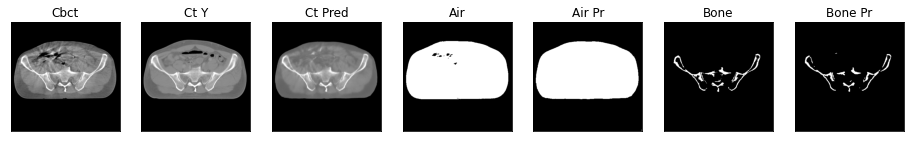

ssim score = 0.8550553917884827
psnr score = 22.93903160095215
snr score = 14.105830192565918
mae error = 0.025572815909981728
air dice score = 0.9911221757715322
bone dice score = 0.8595867877370761


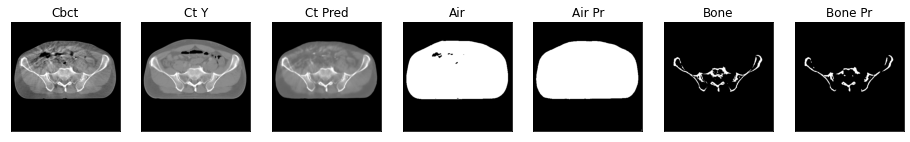

ssim score = 0.8472833633422852
psnr score = 22.6058292388916
snr score = 13.72668743133545
mae error = 0.02648666314780712
air dice score = 0.9902905000745753
bone dice score = 0.8492558198721631


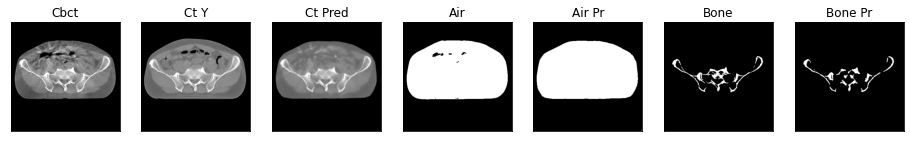

20it [00:43,  2.18s/it]

ssim score = 0.8425754308700562
psnr score = 22.670936584472656
snr score = 13.737997055053711
mae error = 0.026819447055459023
air dice score = 0.988772366627543
bone dice score = 0.8713312693514386


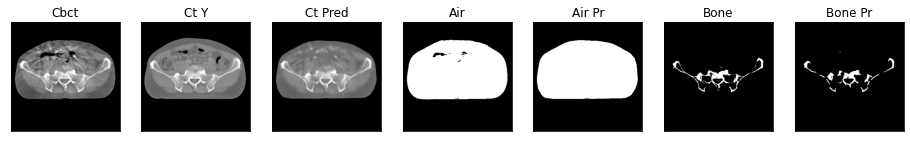

ssim score = 0.8375709056854248
psnr score = 22.4056396484375
snr score = 13.503161430358887
mae error = 0.0279396940022707
air dice score = 0.9875741048138585
bone dice score = 0.8907280796462668


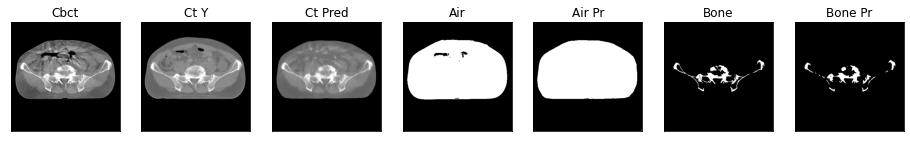

ssim score = 0.8345111012458801
psnr score = 21.989227294921875
snr score = 13.031522750854492
mae error = 0.028315633535385132
air dice score = 0.9880140377561867
bone dice score = 0.8734304369679379


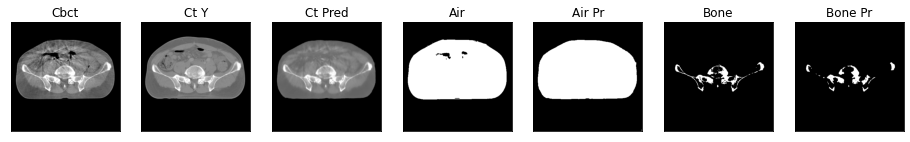

ssim score = 0.8418443202972412
psnr score = 22.566829681396484
snr score = 13.461594581604004
mae error = 0.026521766558289528
air dice score = 0.9889741512161885
bone dice score = 0.8956043956057613


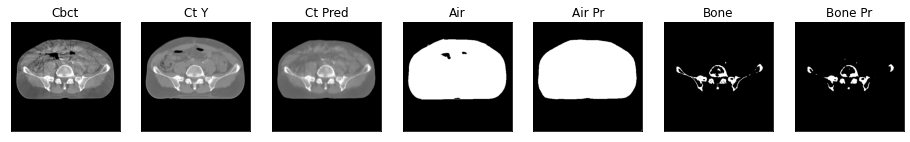

ssim score = 0.8843304514884949
psnr score = 26.67825698852539
snr score = 17.05916976928711
mae error = 0.0159749798476696
air dice score = 0.9944982004838084
bone dice score = 0.9527709527722421


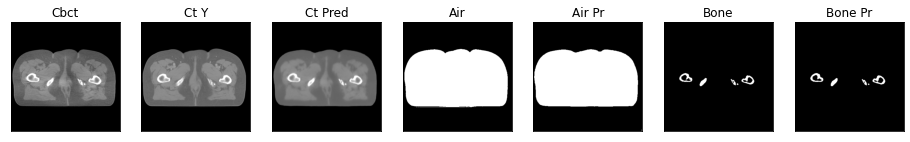

ssim score = 0.8840422630310059
psnr score = 26.791194915771484
snr score = 17.293121337890625
mae error = 0.016010882332921028
air dice score = 0.9943872092852892
bone dice score = 0.9493150684943079


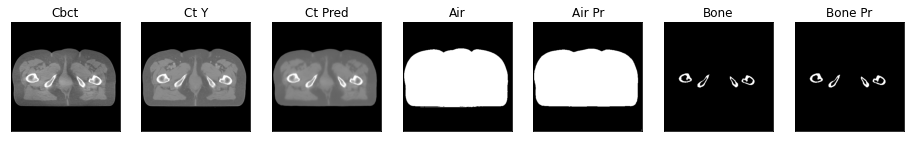

ssim score = 0.8806677460670471
psnr score = 26.74623680114746
snr score = 17.331077575683594
mae error = 0.01645769365131855
air dice score = 0.9944389448553002
bone dice score = 0.9363750523244794


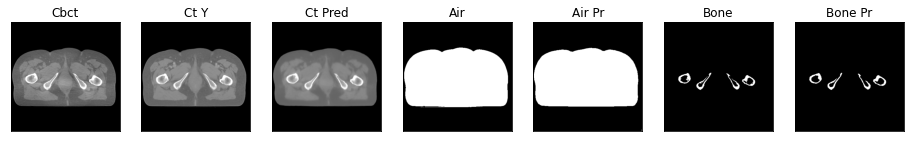

ssim score = 0.8764957785606384
psnr score = 26.577293395996094
snr score = 17.225582122802734
mae error = 0.016878247261047363
air dice score = 0.9943623188405838
bone dice score = 0.9405810684172338


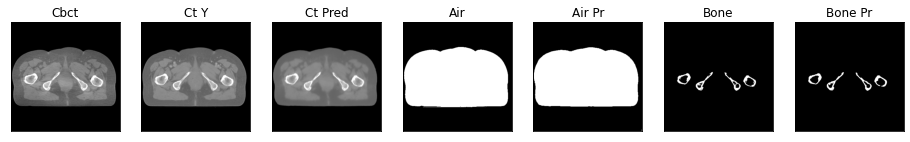

21it [00:46,  2.13s/it]

ssim score = 0.8750792145729065
psnr score = 26.293487548828125
snr score = 16.97023582458496
mae error = 0.017341608181595802
air dice score = 0.9938888728365498
bone dice score = 0.937824762588464


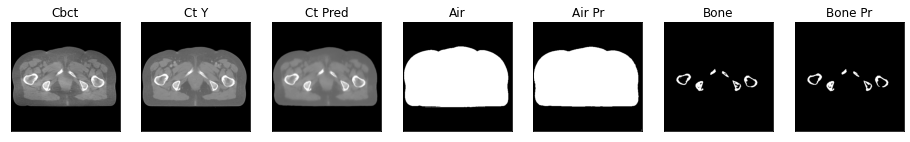

ssim score = 0.8765227794647217
psnr score = 26.28972625732422
snr score = 16.98942756652832
mae error = 0.017034877091646194
air dice score = 0.9945141178672773
bone dice score = 0.9392306262787729


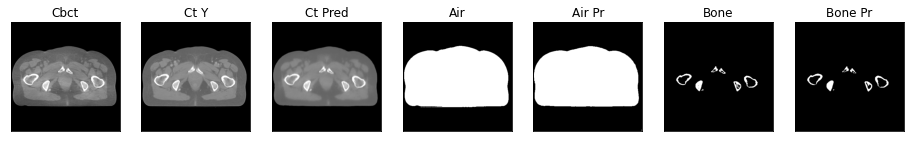

ssim score = 0.8726601004600525
psnr score = 26.103519439697266
snr score = 16.834550857543945
mae error = 0.017459610477089882
air dice score = 0.9947882595662432
bone dice score = 0.9348854128785943


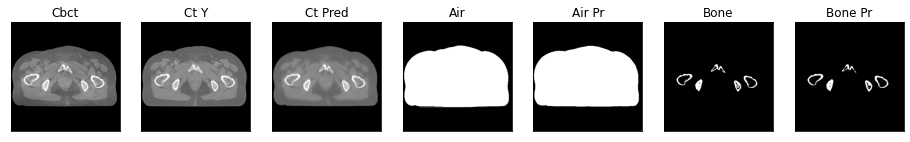

ssim score = 0.8737517595291138
psnr score = 26.108306884765625
snr score = 16.88770294189453
mae error = 0.0178828164935112
air dice score = 0.994478073860254
bone dice score = 0.929632945390696


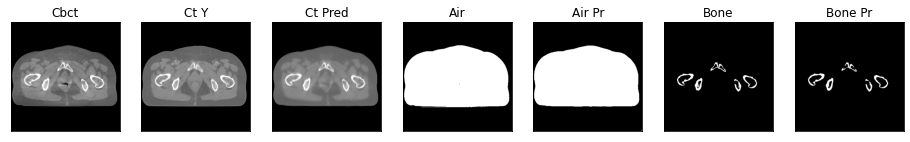

ssim score = 0.873787522315979
psnr score = 26.0128173828125
snr score = 16.83495330810547
mae error = 0.017739692702889442
air dice score = 0.9932805926861884
bone dice score = 0.9303808085903308


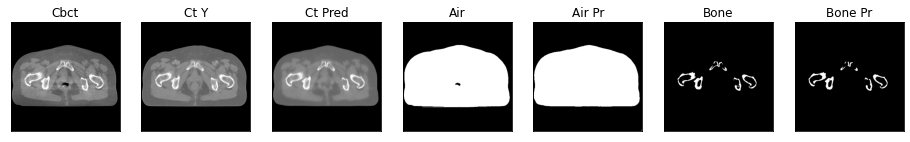

ssim score = 0.873093843460083
psnr score = 26.214202880859375
snr score = 17.124040603637695
mae error = 0.017702272161841393
air dice score = 0.9925534814984917
bone dice score = 0.9058927000893302


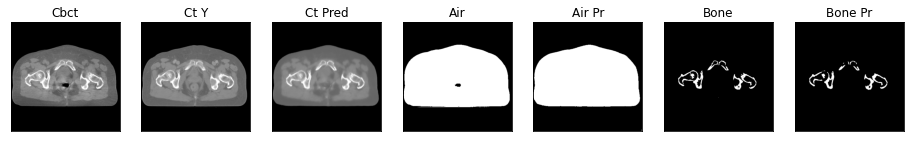

ssim score = 0.8743247389793396
psnr score = 26.56022071838379
snr score = 17.58333396911621
mae error = 0.01768580824136734
air dice score = 0.99385169721754
bone dice score = 0.9161904761914739


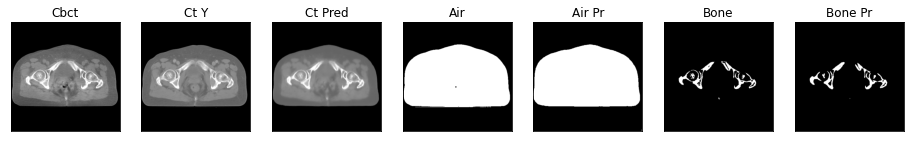

ssim score = 0.8796002268791199
psnr score = 27.03923797607422
snr score = 17.933795928955078
mae error = 0.016834447160363197
air dice score = 0.992185880250229
bone dice score = 0.8826192964144441


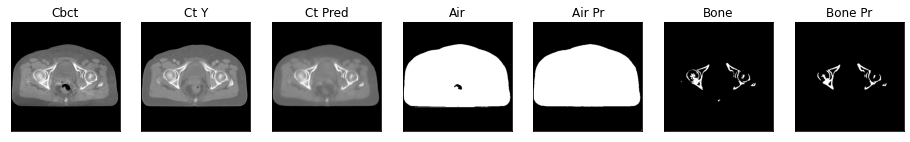

22it [00:48,  2.17s/it]

ssim score = 0.8787480592727661
psnr score = 27.138671875
snr score = 17.923810958862305
mae error = 0.016857968643307686
air dice score = 0.9911723113403008
bone dice score = 0.87768659632908


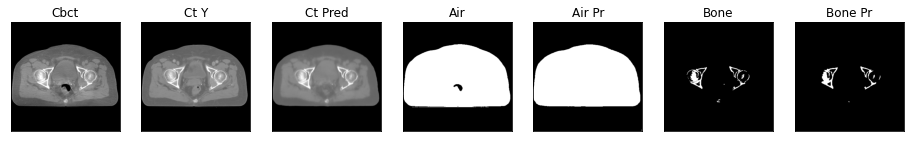

ssim score = 0.8807775974273682
psnr score = 26.95856285095215
snr score = 17.716575622558594
mae error = 0.017384391278028488
air dice score = 0.9915444397746194
bone dice score = 0.898195198880354


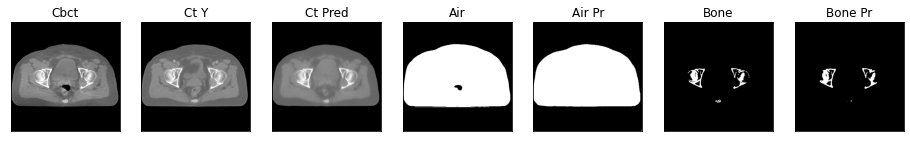

ssim score = 0.8810866475105286
psnr score = 26.61745834350586
snr score = 17.36746597290039
mae error = 0.01833266206085682
air dice score = 0.9933990363866669
bone dice score = 0.9159284639826855


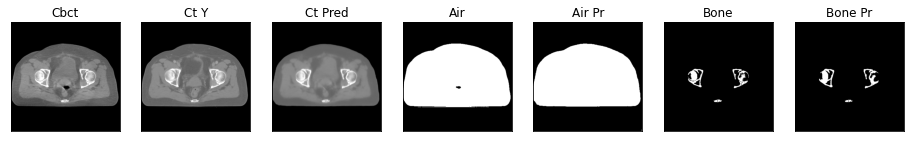

ssim score = 0.8766457438468933
psnr score = 26.72536849975586
snr score = 17.509605407714844
mae error = 0.0174496341496706
air dice score = 0.9939457789015353
bone dice score = 0.9324536600701783


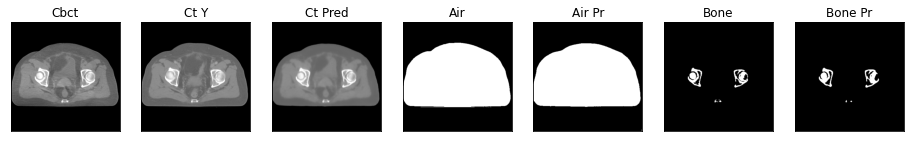

ssim score = 0.8729539513587952
psnr score = 26.378820419311523
snr score = 17.214548110961914
mae error = 0.017776528373360634
air dice score = 0.9941518837347129
bone dice score = 0.9495391345110211


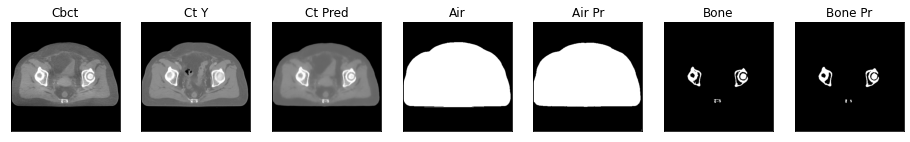

ssim score = 0.8627511262893677
psnr score = 25.458087921142578
snr score = 16.331375122070312
mae error = 0.01923963613808155
air dice score = 0.9947269120990796
bone dice score = 0.9474587912096933


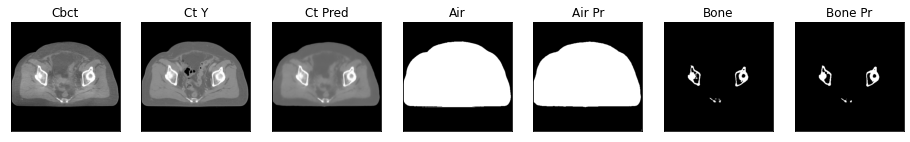

ssim score = 0.8497442007064819
psnr score = 24.042348861694336
snr score = 14.84320068359375
mae error = 0.02181830070912838
air dice score = 0.9940457837434178
bone dice score = 0.9354910219477834


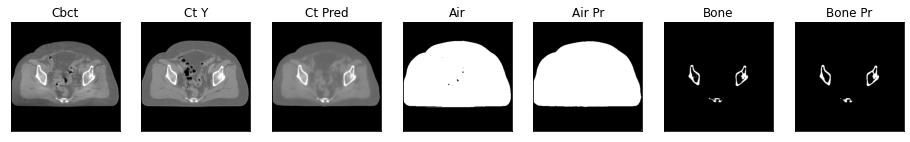

ssim score = 0.8465451002120972
psnr score = 23.990144729614258
snr score = 14.773001670837402
mae error = 0.022538864985108376
air dice score = 0.9926884177736112
bone dice score = 0.9414965986407824


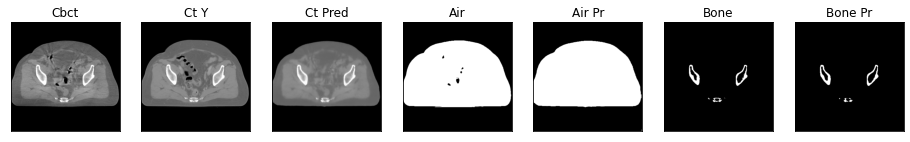

23it [00:50,  2.19s/it]

ssim score = 0.8466862440109253
psnr score = 24.516273498535156
snr score = 15.364044189453125
mae error = 0.022053396329283714
air dice score = 0.9933705301556792
bone dice score = 0.9428571428583797


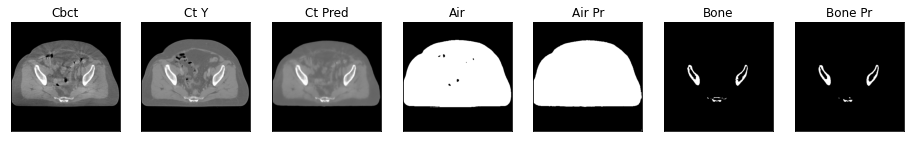

ssim score = 0.8444582223892212
psnr score = 24.178667068481445
snr score = 15.081533432006836
mae error = 0.022812236100435257
air dice score = 0.9933318648751521
bone dice score = 0.946307494961585


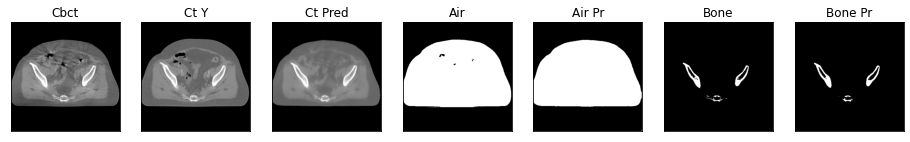

ssim score = 0.8411968350410461
psnr score = 23.839815139770508
snr score = 14.807107925415039
mae error = 0.023735249415040016
air dice score = 0.9935468514453508
bone dice score = 0.9425888871795816


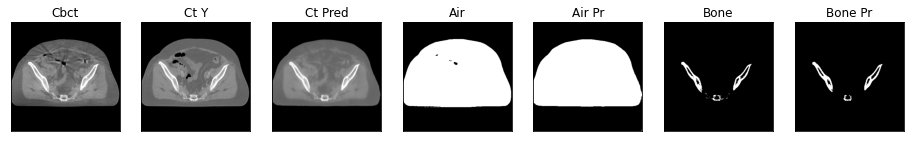

ssim score = 0.8421100974082947
psnr score = 23.891952514648438
snr score = 14.932104110717773
mae error = 0.024050626903772354
air dice score = 0.992785939139564
bone dice score = 0.9125986553652061


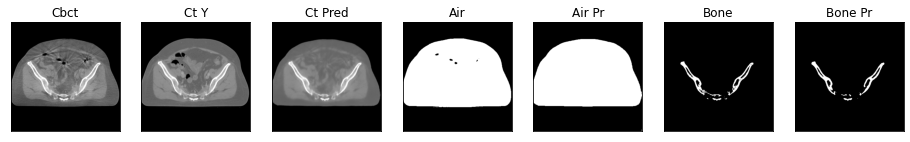

ssim score = 0.8424450159072876
psnr score = 24.07021713256836
snr score = 15.106081008911133
mae error = 0.02379496954381466
air dice score = 0.9927280769080715
bone dice score = 0.9110851126073255


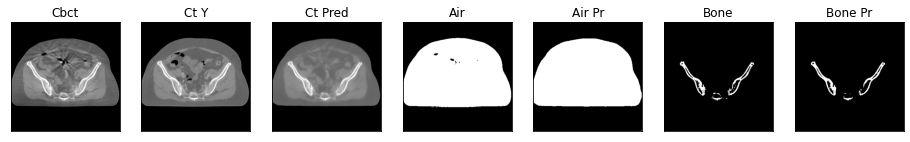

ssim score = 0.838053286075592
psnr score = 23.70928192138672
snr score = 14.722970962524414
mae error = 0.02434183657169342
air dice score = 0.9932644292184458
bone dice score = 0.9057400112562501


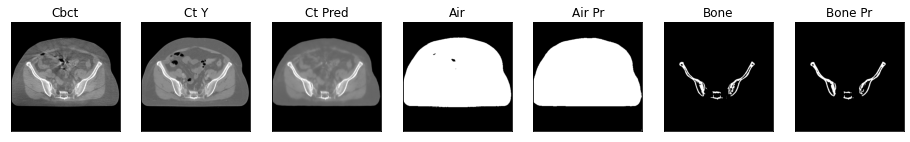

ssim score = 0.8419867753982544
psnr score = 24.129535675048828
snr score = 15.15485668182373
mae error = 0.023543423041701317
air dice score = 0.9937854806812331
bone dice score = 0.9181831631910314


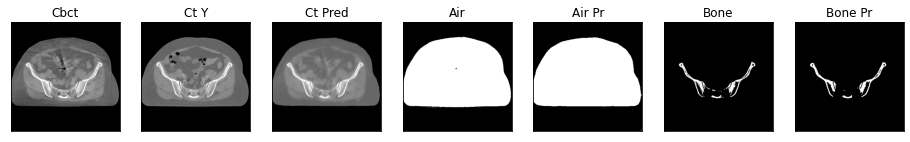

24it [00:52,  2.18s/it]


In [34]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [35]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [37]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
eval_epoch(model, discriminator, testloader, device)

24it [00:05,  4.26it/s]


(0.8573008875052134,
 24.418761730194092,
 15.433332125345865,
 0.023386532401976485,
 0.9937446331851119,
 0.9173123869666732,
 0.5)

In [38]:
# import torchvision.models as models
# models.vgg16(pretrained=True)